# Crime and Parks

For our final project we wanted to know whether areas with more parks had less crime than areas with fewer or no parks.

In order to investigate this question we decided to look at crime and park data from 5 major cities: New York City, Chicago, Philadelphia, Boston, and San Francisco. Because we are looking at a geographic connection, we decided to look at only one year at a time. We looked at only the year 2016.

For data we will use:

* Park or "Open Space" data or shapefiles from:
  * New York City: https://data.cityofnewyork.us/Recreation/Open-Space-Parks-/g84h-jbjm
  * Chicago: https://dev.socrata.com/foundry/data.cityofchicago.org/ejsh-fztr
  * Philadelphia: https://www.opendataphilly.org/dataset/parks-and-recreation-assets
  * Boston: https://data.boston.gov/dataset/open-space
  * San Francisco: https://data.sfgov.org/Culture-and-Recreation/Park-and-Open-Space-Map/4udc-s3pr


* Common geographical areas from:
  * New York City: https://dev.socrata.com/foundry/data.cityofnewyork.us/kmub-vria
  * Chicago: https://dev.socrata.com/foundry/data.cityofchicago.org/igwz-8jzy
  * Philadelphia: https://www.opendataphilly.org/dataset/police-districts
  *               https://services.arcgis.com/fLeGjb7u4uXqeF9q/arcgis/rest/services/Boundaries_District/FeatureServer/0/query?outFields=*&where=1%3D1
  * Boston: http://bostonopendata-boston.opendata.arcgis.com/datasets/9a3a8c427add450eaf45a470245680fc_5.zip (Shape file, not a landing page)
  * San Francisco: https://dev.socrata.com/foundry/data.sfgov.org/q52f-skbd
  

* Crime APIs and data from:
  * New York City: https://dev.socrata.com/foundry/data.cityofnewyork.us/9s4h-37hy
  * Chicago: https://dev.socrata.com/foundry/data.cityofchicago.org/6zsd-86xi
  * Philadelphia: https://cityofphiladelphia.github.io/carto-api-explorer/#incidents_part1_part2
  * Boston: https://data.boston.gov/dataset/crime-incident-reports-august-2015-to-date-source-new-system
  * San Francisco: https://dev.socrata.com/foundry/data.sfgov.org/cuks-n6tp

Boston does not have an API interface, so we will instead download the csv directly. Luckily Boston switched from an old system to a new system, so the csv file we are interested in only has data from August 2015 to present, which will make it less arduous to download and work with.

In [24]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely.geometry import shape
from shapely.geometry import Point


import requests, json

import pandas as pd
import seaborn as sns
sns.set_style({"axes.grid": "False"}, {'axes.axisbelow': "False"})
sns.set_style({"axes.linewidth": 0})

import pytz
import datetime

from urllib.parse import quote

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.regression.mixed_linear_model as sm_mlm

from time import sleep

### Chicago

We will acquire the data for crime in Chicago similarly to how we did in class for the Weather and Crime example.

In [25]:
soql = "https://data.cityofchicago.org/resource/6zsd-86xi.json?$query="
soql += quote("SELECT id, community_area, primary_type ")
soql += quote("WHERE year == 2016 ")
soql += quote("LIMIT 300000")

resp = requests.get(soql).json()
chicago_crime = pd.DataFrame(resp)
chi_CA_count = chicago_crime.groupby("community_area").count()

In [26]:
soql = "https://data.cityofchicago.org/resource/igwz-8jzy.json?$query="
soql += quote("SELECT area_numbe as Number, community, the_geom ")
soql += quote("LIMIT 300000")

resp = requests.get(soql).json()

Because the data is downloaded as a json object, and thus parsed as a dictionary, we must convert it into geopandas data frame. 

In [27]:
data = resp
for d in data:
    d['the_geom'] = shape(d['the_geom'])

chicago_comm_areas = gpd.GeoDataFrame(data).set_geometry('the_geom')
chicago_comm_areas.crs = {'init' :'epsg:4269'}
chicago_comm_areas.head()

Number        community                                           the_geom
0     35          DOUGLAS  (POLYGON ((-87.60914087617894 41.8446925026539...
1     36          OAKLAND  (POLYGON ((-87.59215283879394 41.8169293462668...
2     37      FULLER PARK  (POLYGON ((-87.62879823733725 41.8018930336891...
3     38  GRAND BOULEVARD  (POLYGON ((-87.6067081256125 41.81681377057218...
4     39          KENWOOD  (POLYGON ((-87.59215283879394 41.8169293462668...

In [28]:
chi_CA_count = chi_CA_count.reset_index()
chicago_comm_areas = chicago_comm_areas.merge(chi_CA_count, left_on = 'Number', right_on = 'community_area')

We want to be able to visualize the degree of crime in each community area of Chicago before we analyze the amount of park space. In order to do so, we’ll start by creating a chloropleth map that shows the crime levels of each area.

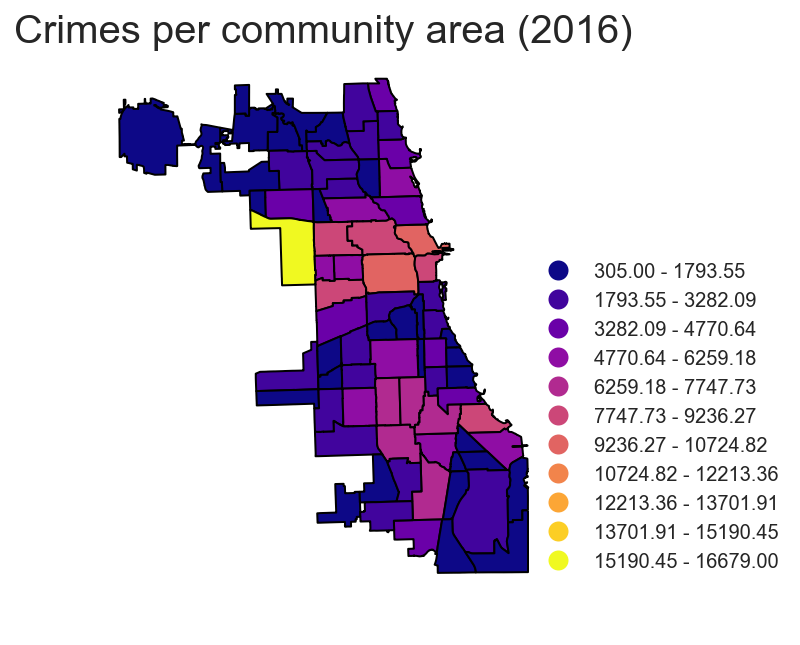

In [29]:
CAMap = chicago_comm_areas.to_crs(epsg = 3528).plot(column = 'id', scheme = 'equal_interval', k = 11, cmap = 'plasma', legend=True,
                               linewidth = 1, edgecolor = 'black', figsize = (9,5))
CAMap.set_title("Crimes per community area (2016)", fontsize = 20)
CAMap.set_axis_off()
CAMap.get_legend().set_bbox_to_anchor((1.55, .65))
CAMap.get_legend().get_frame().set_linewidth(0)

In [30]:
chi_CA_count.set_index('community_area', inplace = True)

This map is a useful visual representation. In order to see rank community areas by crime, however, we’ll want to create a bar graph with community areas labeled.

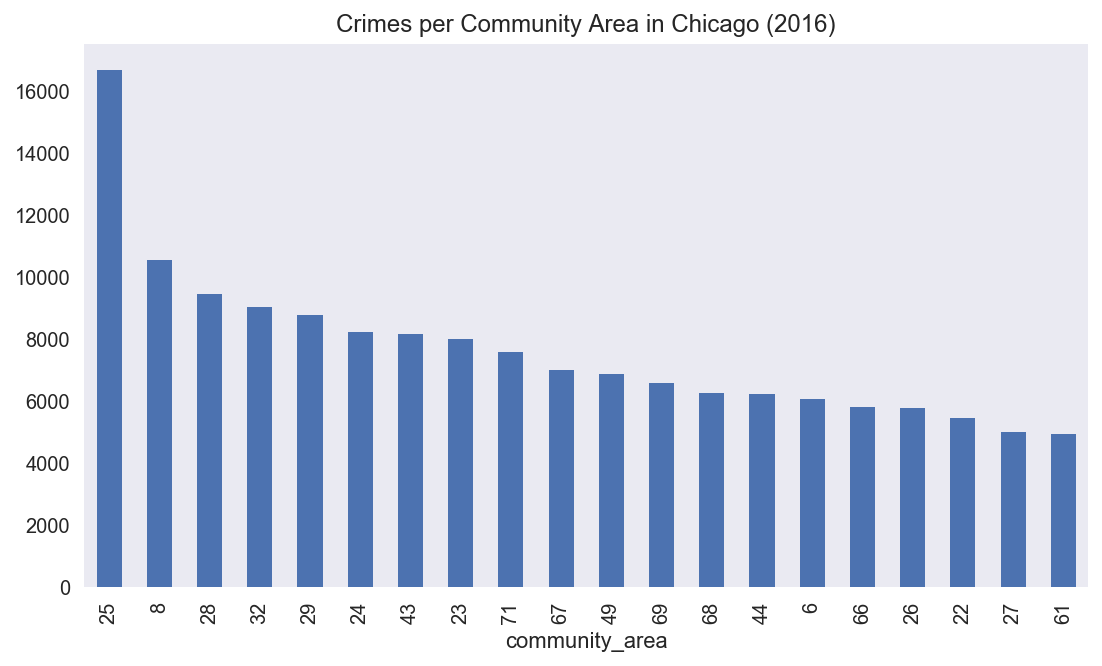

In [31]:
CAGraph = chi_CA_count.sort_values('id', ascending = False)['id'].head(20).plot.bar(figsize = (9, 5))
CAGraph.set_title('Crimes per Community Area in Chicago (2016)')

Community area 25 is by far the highest total amount of crime in 2016. However, we are unsure if that is just because it's an especially highly populated area. In order to verify that, we’ll create a new variable: “Crimes per person,” listed by community area. 

In [32]:
CAPop = pd.read_csv("CAPop.csv", dtype={'Community Area': str})

In [33]:
chicago_comm_areas = chicago_comm_areas.merge(CAPop, left_on = "community_area", right_on = "Community Area")

In [34]:
chicago_comm_areas.head()

Number        community                                           the_geom  \
0     35          DOUGLAS  (POLYGON ((-87.60914087617894 41.8446925026539...   
1     36          OAKLAND  (POLYGON ((-87.59215283879394 41.8169293462668...   
2     37      FULLER PARK  (POLYGON ((-87.62879823733725 41.8018930336891...   
3     38  GRAND BOULEVARD  (POLYGON ((-87.6067081256125 41.81681377057218...   
4     39          KENWOOD  (POLYGON ((-87.59215283879394 41.8169293462668...   

  community_area    id  primary_type Community Area  Population  
0             35  2597          2597             35       18238  
1             36   698           698             36        5918  
2             37   925           925             37        2876  
3             38  3284          3284             38       21929  
4             39  1405          1405             39       17841

In [35]:
chicago_comm_areas['Crimes per person'] = chicago_comm_areas['id']/chicago_comm_areas['Population']

In [36]:
chicago_comm_areas.head()

Number        community                                           the_geom  \
0     35          DOUGLAS  (POLYGON ((-87.60914087617894 41.8446925026539...   
1     36          OAKLAND  (POLYGON ((-87.59215283879394 41.8169293462668...   
2     37      FULLER PARK  (POLYGON ((-87.62879823733725 41.8018930336891...   
3     38  GRAND BOULEVARD  (POLYGON ((-87.6067081256125 41.81681377057218...   
4     39          KENWOOD  (POLYGON ((-87.59215283879394 41.8169293462668...   

  community_area    id  primary_type Community Area  Population  \
0             35  2597          2597             35       18238   
1             36   698           698             36        5918   
2             37   925           925             37        2876   
3             38  3284          3284             38       21929   
4             39  1405          1405             39       17841   

   Crimes per person  
0           0.142395  
1           0.117945  
2           0.321627  
3           0.149756  
4           0.078751

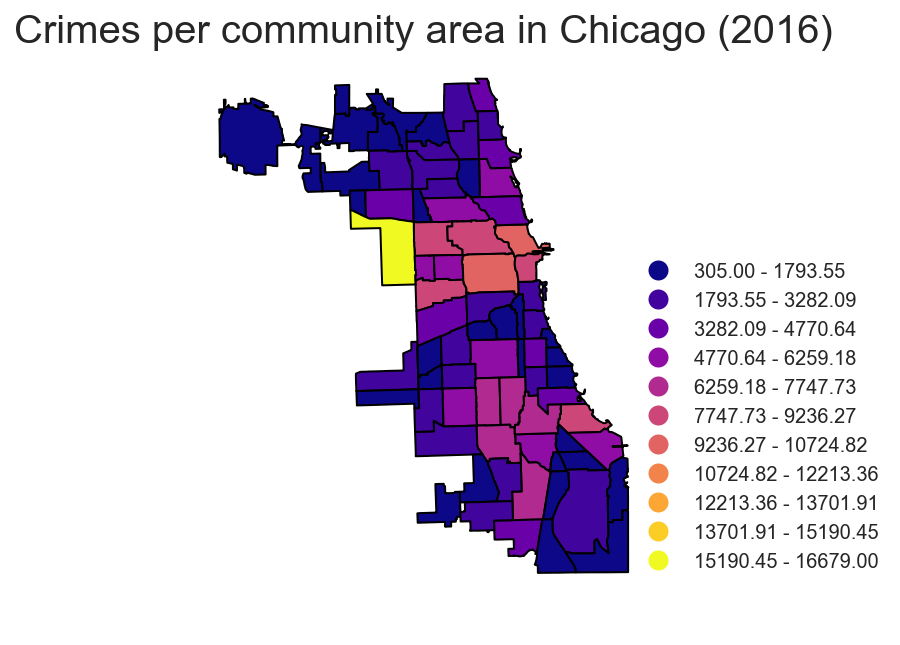

In [37]:
CAMap = chicago_comm_areas.to_crs(epsg = 3528).plot(column = 'id', scheme = 'equal_interval',
                                                    k = 11, cmap = 'plasma', legend=True,
                                                    linewidth = 1, edgecolor = 'black', figsize = (9,5))
CAMap.set_title("Crimes per community area in Chicago (2016)", fontsize = 20)
CAMap.set_axis_off()
CAMap.get_legend().set_bbox_to_anchor((1.55, .65))
CAMap.get_legend().get_frame().set_linewidth(0)

The central community areas in particular show a marked difference in our mapped crime measure. This makes sense given that these are Chicago’s most populous communities, and are not particularly high in crime relative to other areas.

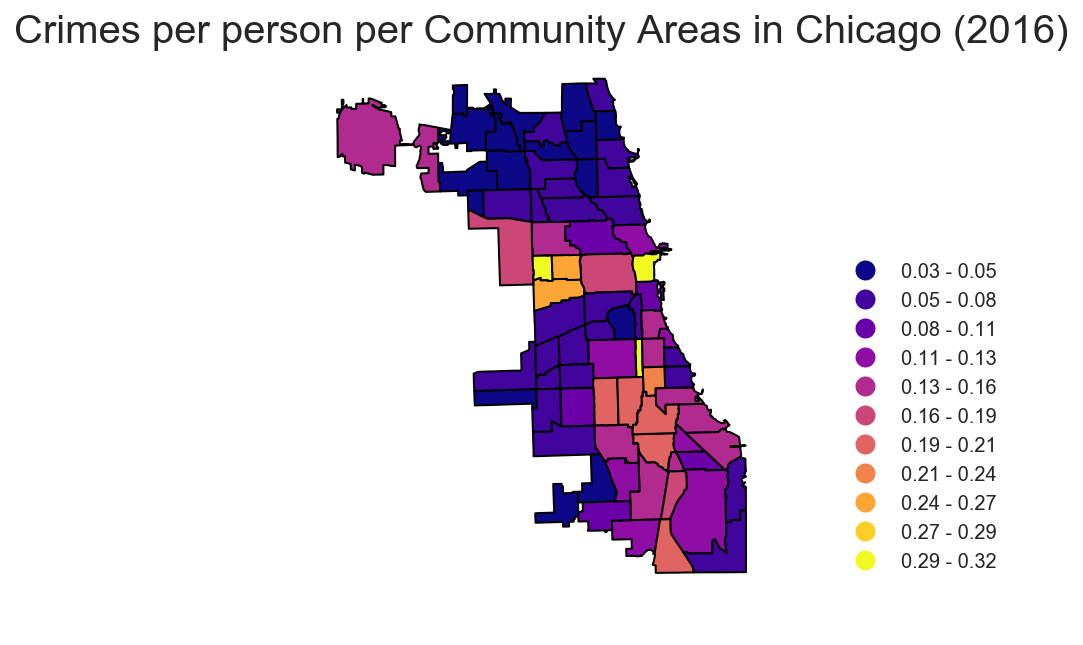

In [38]:
PerPerson = chicago_comm_areas.to_crs(epsg = 3528).plot(column = 'Crimes per person',
                                                        scheme='equal_interval', k = 11, cmap = 'plasma', legend=True,
                                                        linewidth = 1, edgecolor = 'black', figsize = (9,5))
PerPerson.set_title("Crimes per person per Community Areas in Chicago (2016)", fontsize = 20)
PerPerson.set_axis_off()

PerPerson.get_legend().set_bbox_to_anchor((1.55, .65))

The map looks slightly different now that we adjusted for population in the community areas.

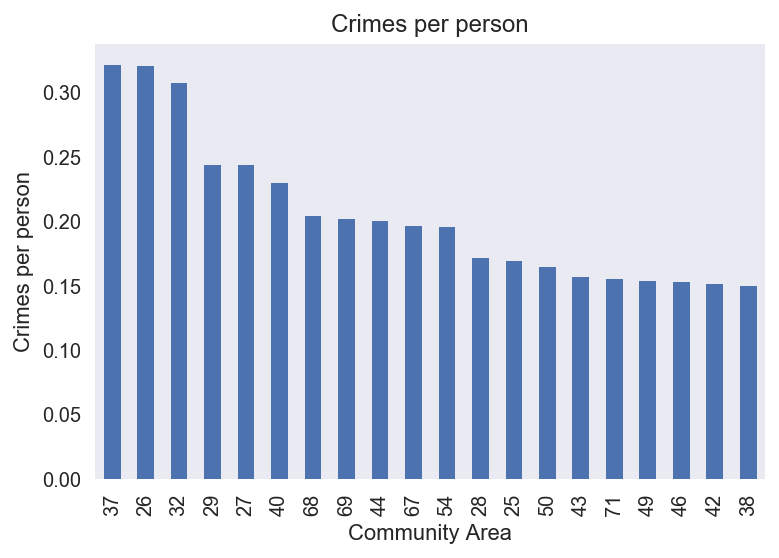

In [39]:
CPP = chicago_comm_areas[['Number','Crimes per person']].sort_values('Crimes per person', ascending = False).head(20).plot.bar('Number', 'Crimes per person')
CPP.set_title("Crimes per person")
CPP.set_xlabel("Community Area")
CPP.set_ylabel("Crimes per person")
CPP.legend_.remove()

In [40]:
chicago_comm_areas.set_index('Number', inplace = True)

In [41]:
chicago_comm_areas[['id','Crimes per person']].sort_values('Crimes per person', ascending = False).head(20)

id  Crimes per person
Number                          
37        925           0.321627
26       5772           0.320649
32       9016           0.307892
29       8766           0.244097
27       5016           0.243886
40       2695           0.230008
68       6270           0.204541
69       6580           0.201828
44       6233           0.200883
67       6990           0.196874
54       1271           0.196081
28       9445           0.172100
25      16679           0.169306
50       1206           0.164642
43       8163           0.156951
71       7582           0.155551
49       6860           0.153746
46       4781           0.153247
42       3604           0.151811
38       3284           0.149756

Indeed, community areas 37 and 26 are the highest rate of crimes per person, whereas 25 is still high, but not the highest area.

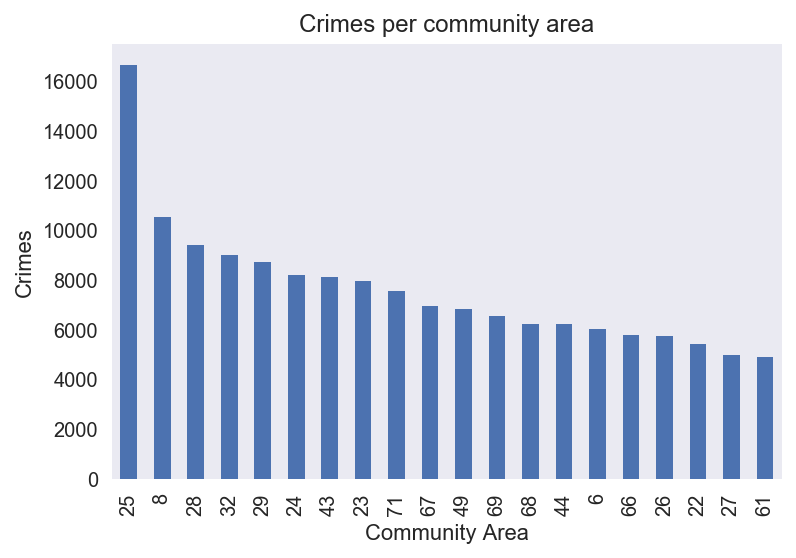

In [42]:
CCA = chi_CA_count.sort_values('id', ascending = False)['id'].head(20).plot.bar()
CCA.set_title("Crimes per community area")
CCA.set_xlabel("Community Area")
CCA.set_ylabel("Crimes")

Full credit to Professor Saxon for providing cleaned geojson and the code to assess the park area and distance to a park from class. We attempted to download the data freshly ourselves from City of Chicago, but had trouble with projections aligning. The geodataframes were formatted in some way such that any analysis of buffers were being done in degrees, rather than km.

In [43]:
tracts = gpd.read_file("chicago_tracts.geojson").to_crs(epsg = 3528)
parks  = gpd.read_file("chicago_parks.geojson") .to_crs(epsg = 3528)

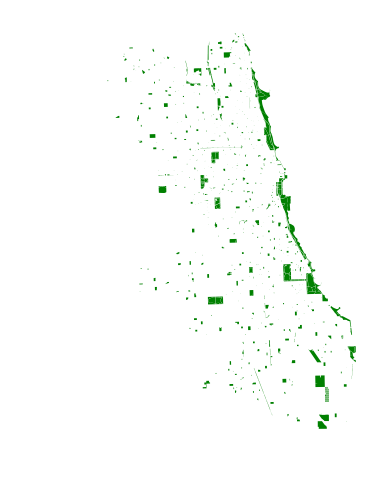

In [ ]:
puu = parks.unary_union
tuu = tracts.unary_union

ax = parks.plot(color = "green")
ax.set_axis_off()
# ax.figure.savefig("individual_parks.pdf")

In [ ]:
tracts["park_area"] = tracts.centroid.buffer(500).intersection(puu).area
tracts["distance"]  = tracts.centroid.distance(puu)

The map below display park area by Census Tract. Unsurprisingly, tracts around Lake Michigan have a disproportionately high park area. 

In [ ]:
parkplot = tracts.plot(column = "park_area", cmap = "Greens", edgecolor="black",
                       scheme = "quantiles", k=11,
                       legend = True, figsize = (12, 12))
parkplot.set_axis_off()
parkplot.set_title("Parks per Census Tract in Chicago (2016)", fontsize = 20)

I downloaded crime data from the past year as a geojson.

In [ ]:
chicago_crimes = gpd.read_file("chicago_crimes.geojson").to_crs(epsg = 3528)

In [ ]:
chicago_crimes.crs

In [ ]:
tracts.crs

In [ ]:
tract_crime_count = gpd.sjoin(chicago_crimes, tracts, how = 'left', op = 'within')

In [ ]:
tract_crime_count.head()

In [ ]:
count = tract_crime_count.groupby('namelsad10').count()['id']

In [ ]:
count = pd.DataFrame(count)

In [ ]:
count.head()

In [ ]:
crime_tracts = pd.merge(tracts, count, left_on = "namelsad10", right_index = True)

In [ ]:
crime_tracts['Count'] = crime_tracts['id']

“Hotter” colors denote higher rates of crime. Using census tracts instead of community areas also highlight more localized crime hotspots. Another thing to note is that the “hottest” tract (yellow area) has little to no park space. See park map above.

In [ ]:
CTPlot = crime_tracts.plot(column = 'Count', cmap = 'plasma', edgecolor = 'white', legend = True, figsize = (12, 12))

CTPlot.set_axis_off()
CTPlot.set_title("Crimes per Census Tract in Chicago (2016)", fontsize = 20)

In [ ]:
crime_tracts.sort_values('namelsad10').head()

In [ ]:
addr = 'https://api.census.gov/data/2015/acs/acs5?get=NAME,B01001_001E&for=tract:*&in=state:17&in=county:031'
resp = requests.get(addr)

In [ ]:
json = resp.json()

In [ ]:
pop = pd.DataFrame(json)

In [ ]:
pop.head()

In [ ]:
pop.columns.values

In [ ]:
pop.columns = pop.iloc[0]

In [ ]:
pop = pop.drop(0)

In [ ]:
pop['numeric'] = pd.to_numeric(pop['tract'])/100.0

In [ ]:
crime_tracts['numeric'] = pd.to_numeric(crime_tracts['name10'])

In [ ]:
crime_tracts.head()

In [ ]:
merged = pd.merge(crime_tracts, pop, left_on = 'numeric', right_on = 'numeric')

In [ ]:
merged = gpd.GeoDataFrame(merged)

Below is a plot of crimes per census tract. We divided the tracts by equal interval in this map.

Instead of using a continuous gradient like the previous map, this map uses equal intervals.

In [ ]:
CTEIPlot = merged.plot(column = 'Count', cmap = 'plasma', scheme = 'equal_interval', k = 11,
                       edgecolor = 'white', legend = True,
                       figsize = (12, 12))

CTEIPlot.set_axis_off()
CTEIPlot.set_title("Crimes per Census Tract in Chicago (2016)", fontsize = 20)

In [254]:
merged['Population'] = pd.to_numeric(merged['B01001_001E'])

In [255]:
merged.head()

statefp10 name10 commarea_n         namelsad10 commarea      geoid10 notes  \
0        17   8424         44  Census Tract 8424       44  17031842400         
1        17   8403         59  Census Tract 8403       59  17031840300         
2        17   8411         34  Census Tract 8411       34  17031841100         
3        17   8412         31  Census Tract 8412       31  17031841200         
4        17   8382         28  Census Tract 8382       28  17031838200         

  tractce10 countyfp10                                           geometry  \
0    842400        031  (POLYGON ((359011.0918414976 562381.5134188498...   
1    840300        031  (POLYGON ((353772.6046558226 572641.0855168948...   
2    841100        031  (POLYGON ((358458.7375946075 575992.5376885971...   
3    841200        031  (POLYGON ((353574.5667614859 576275.6182143808...   
4    838200        031  (POLYGON ((355245.5246228033 578342.4871348761...   

     ...        distance    id  Count  numeric  \
0    ...      188.562540  1064   1064   8424.0   
1    ...      249.580478   234    234   8403.0   
2    ...      316.925605   423    423   8411.0   
3    ...      615.512418   349    349   8412.0   
4    ...      449.379846   392    392   8382.0   

                                       NAME B01001_001E state county   tract  \
0  Census Tract 8424, Cook County, Illinois        3102    17    031  842400   
1  Census Tract 8403, Cook County, Illinois        4025    17    031  840300   
2  Census Tract 8411, Cook County, Illinois        7673    17    031  841100   
3  Census Tract 8412, Cook County, Illinois        5651    17    031  841200   
4  Census Tract 8382, Cook County, Illinois        1969    17    031  838200   

  Population  
0       3102  
1       4025  
2       7673  
3       5651  
4       1969  

[5 rows x 21 columns]

In [256]:
merged['Per Person'] = merged['Count'] / merged['Population']

However, without adjusting for population, we’ll still have especially populated tracts appear to be the ones with the highest rates of crime. Again, we account for this by using crimes per person per tract. There are three "inf" values in the column. So I plot it by removing those instances.

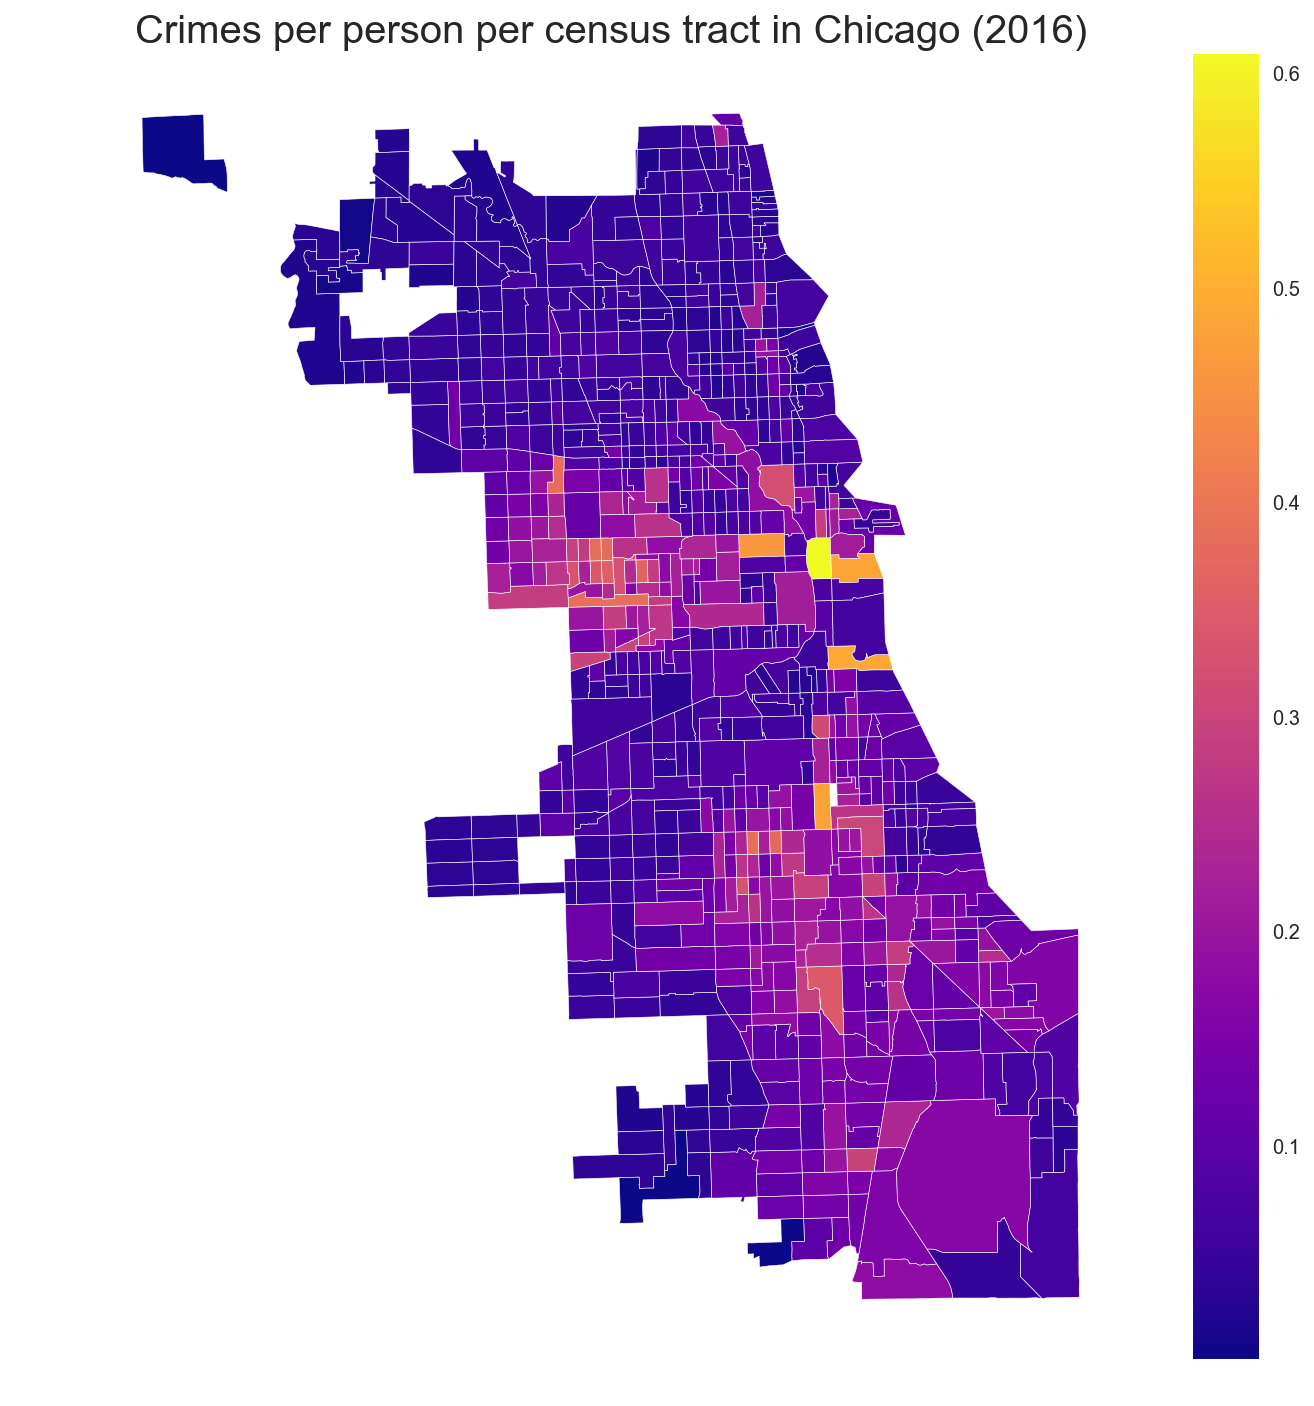

In [257]:
PPChi = merged[~np.isinf(merged['Per Person'])].plot(column = 'Per Person', cmap = 'plasma', edgecolor = 'white', legend = True,
                                             figsize = (12, 12))
PPChi.set_axis_off()
PPChi.set_title('Crimes per person per census tract in Chicago (2016)', fontsize = 20)

Again, this time with equal intervals. 

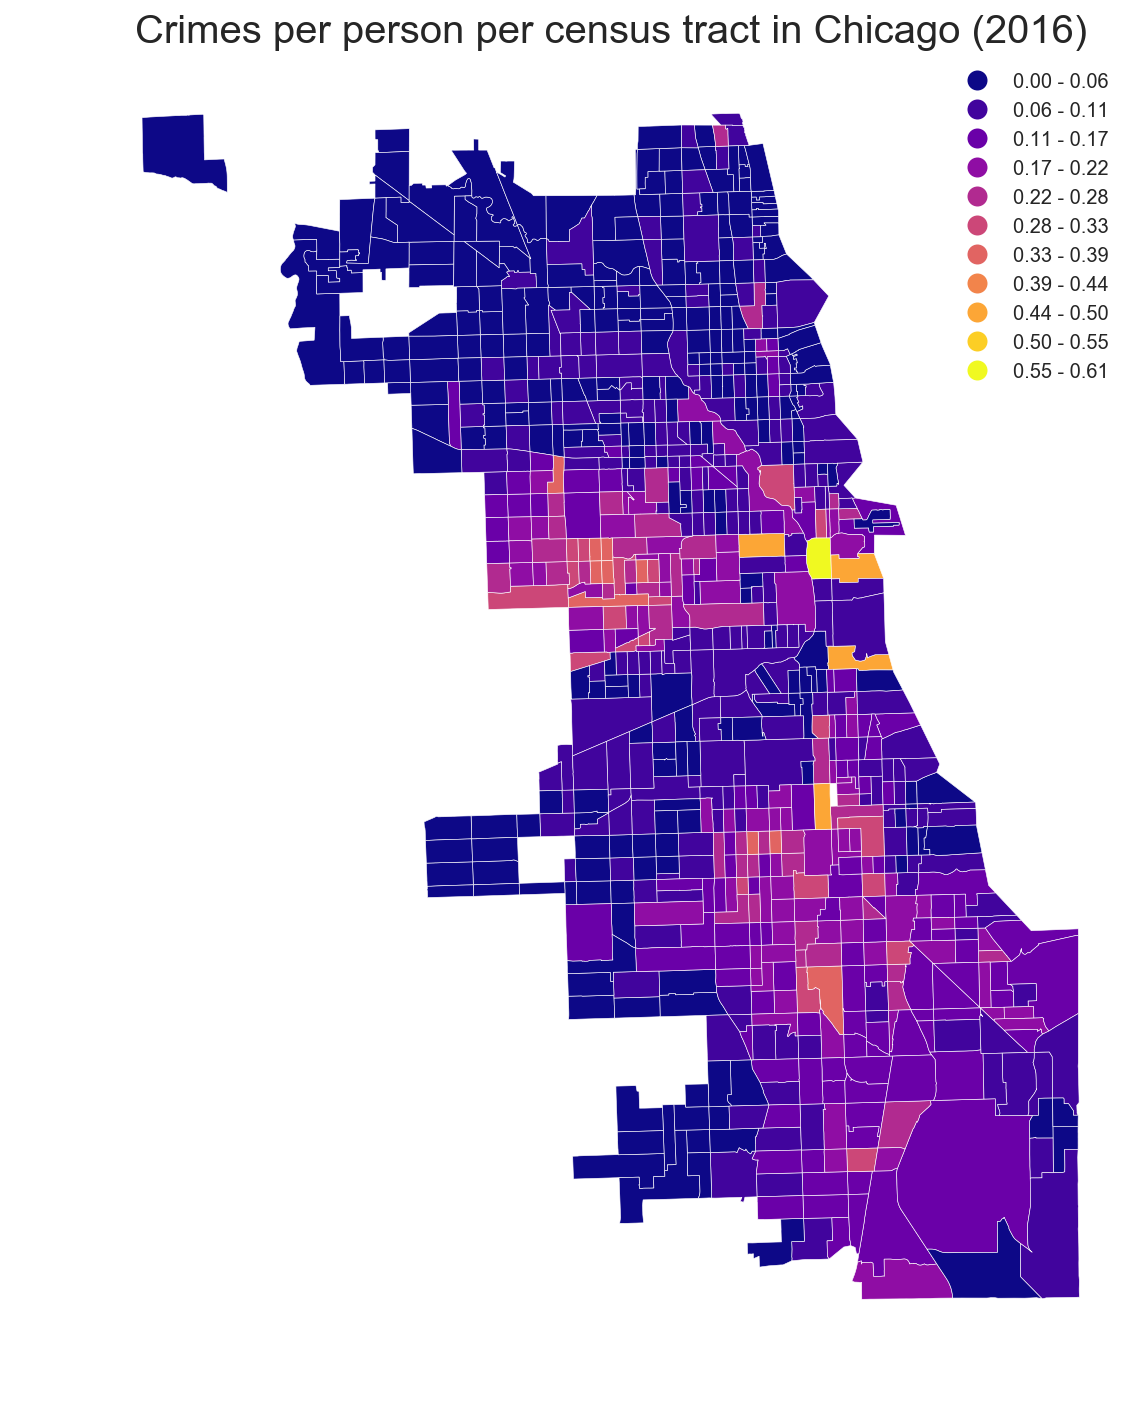

In [258]:
PPChiEI = merged[~np.isinf(merged['Per Person'])].plot(column = 'Per Person', cmap = 'plasma',
                                             scheme = 'equal_interval', k = 11,
                                             edgecolor = 'white', legend = True,
                                             figsize = (12, 12))
PPChiEI.set_axis_off()
PPChiEI.set_title('Crimes per person per census tract in Chicago (2016)', fontsize = 20)

We also use a bar graph here to see crime levels in individual tracts. 

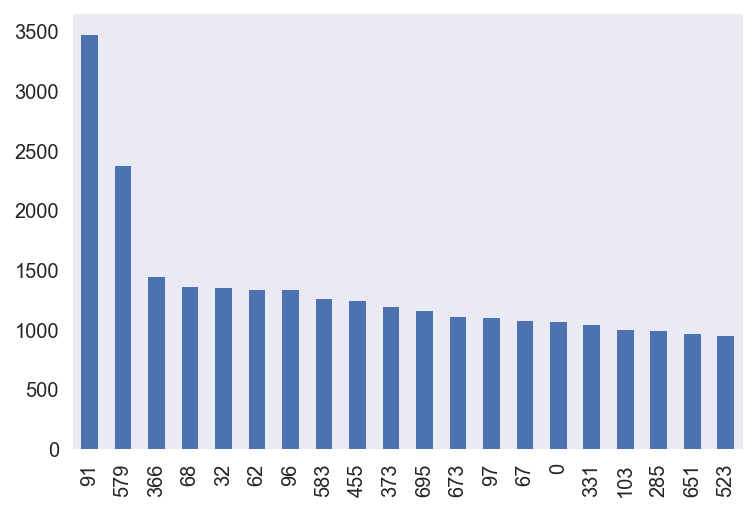

In [259]:
merged['Count'].sort_values(ascending = False).head(20).plot.bar()

In [260]:
merged.columns.values

array(['statefp10', 'name10', 'commarea_n', 'namelsad10', 'commarea',
       'geoid10', 'notes', 'tractce10', 'countyfp10', 'geometry',
       'park_area', 'distance', 'id', 'Count', 'numeric', 'NAME',
       'B01001_001E', 'state', 'county', 'tract', 'Population',
       'Per Person'], dtype=object)

In [261]:
merged.drop(['state', 'county', 'commarea_n', 'namelsad10', 'tractce10', 'countyfp10', 'statefp10', 'B01001_001E', 'tract', 'name10', 'notes'], axis = 1, inplace = True)

In [262]:
merged.head()

commarea      geoid10                                           geometry  \
0       44  17031842400  (POLYGON ((359011.0918414976 562381.5134188498...   
1       59  17031840300  (POLYGON ((353772.6046558226 572641.0855168948...   
2       34  17031841100  (POLYGON ((358458.7375946075 575992.5376885971...   
3       31  17031841200  (POLYGON ((353574.5667614859 576275.6182143808...   
4       28  17031838200  (POLYGON ((355245.5246228033 578342.4871348761...   

      park_area    distance    id  Count  numeric  \
0  55851.593831  188.562540  1064   1064   8424.0   
1   8148.527544  249.580478   234    234   8403.0   
2   6642.280407  316.925605   423    423   8411.0   
3      0.000000  615.512418   349    349   8412.0   
4   3144.627241  449.379846   392    392   8382.0   

                                       NAME  Population  Per Person  
0  Census Tract 8424, Cook County, Illinois        3102    0.343005  
1  Census Tract 8403, Cook County, Illinois        4025    0.058137  
2  Census Tract 8411, Cook County, Illinois        7673    0.055128  
3  Census Tract 8412, Cook County, Illinois        5651    0.061759  
4  Census Tract 8382, Cook County, Illinois        1969    0.199086

We now perform some statistical analysis of the relationship between park area and distance to the nearest park in relation to the crime count in each census tract.

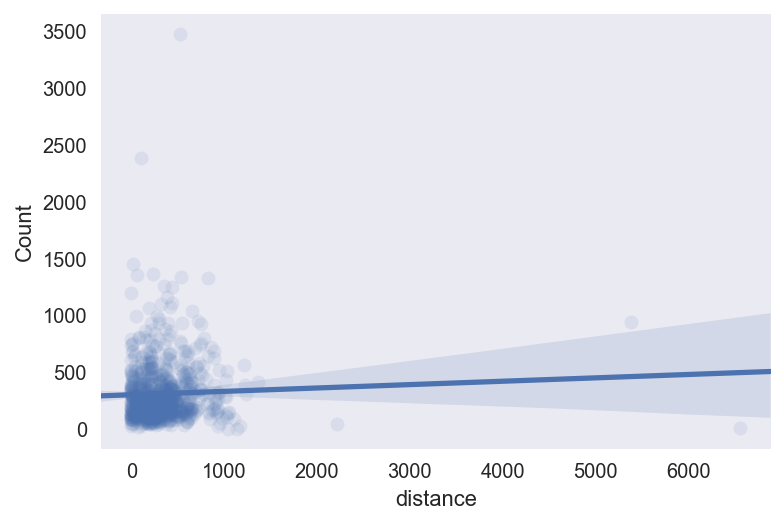

In [263]:
sns.regplot(x = 'distance', y = 'Count',
            data = merged, scatter_kws = {"alpha" : 0.1})

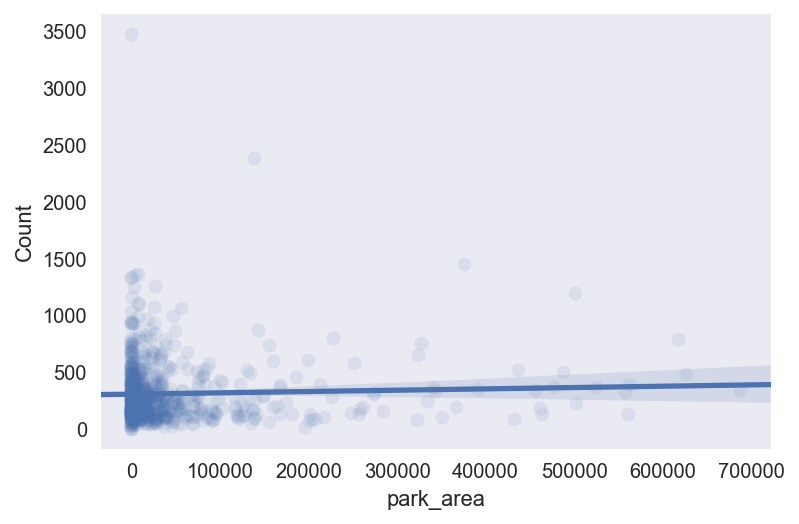

In [264]:
sns.regplot(x = 'park_area', y = 'Count',
            data = merged, scatter_kws = {"alpha" : 0.1})

We can exclude these outliers for a more accurate analysis. 

In [265]:
merged['distance'].sort_values(ascending = False).head()

169    6557.741178
667    5379.383879
129    2211.017616
786    1359.722557
182    1238.367514
Name: distance, dtype: float64

In [266]:
merged['Count'].sort_values(ascending = False).head()

91     3473
579    2377
366    1448
68     1363
32     1354
Name: Count, dtype: int64

There are a few significant outliers in distance and count.

In [267]:
trimmed = merged[merged['Count']<1500]

In [268]:
trimmed = trimmed[trimmed['distance']<1500]

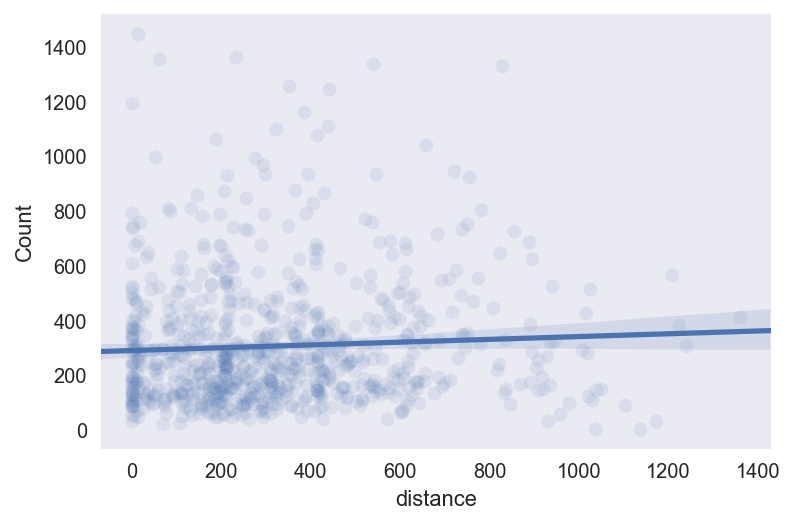

In [269]:
sns.regplot(x = 'distance', y = 'Count',
            data = trimmed, scatter_kws = {"alpha" : 0.1})

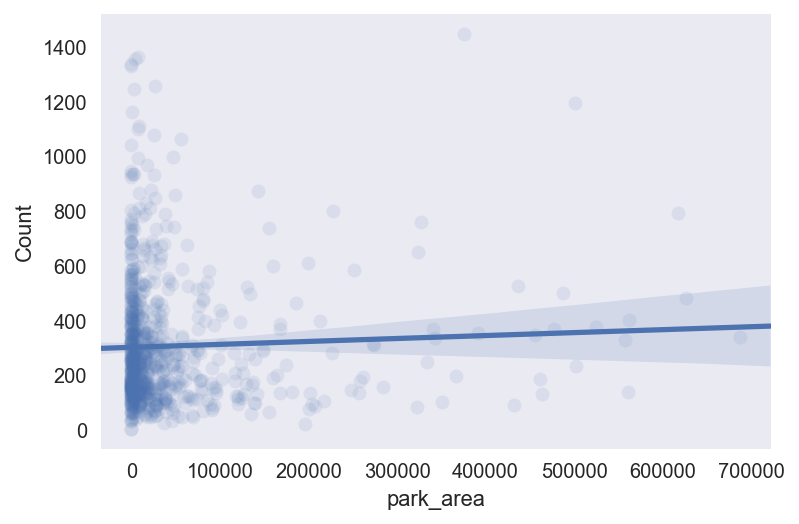

In [270]:
sns.regplot(x = 'park_area', y = 'Count',
            data = trimmed, scatter_kws = {'alpha' : 0.1})

It is difficult to see if there is any effect, so we examine some regressions to see it numerically, rather than graphically.

In [271]:
ols = smf.ols(formula = 'Count ~ park_area + distance',
             data = merged)

model = ols.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Count   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.924
Date:                Fri, 01 Dec 2017   Prob (F-statistic):              0.147
Time:                        19:32:12   Log-Likelihood:                -5602.4
No. Observations:                 801   AIC:                         1.121e+04
Df Residuals:                     798   BIC:                         1.122e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    291.8586     14.269     20.454      0.000     263.849     319.868
park_area      0.0002      0.000      1.541      0.124   -4.54e-05       0.000
distance       0.0408      0.025      1.603      0.109      -0.009       0.091
==============================================================================
Omnibus:                      713.678   Durbin-Watson:                   1.573
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            34141.472
Skew:                           3.801   Prob(JB):                         0.00
Kurtosis:                      34.067   Cond. No.                     1.53e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.53e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

It seems that distance to the nearest park almost has a significant relationship, but it is unclear if it even gets the direction correct, given the confidence interval spans across 0. We can control for census demographical information, however.

In [272]:
addr = 'https://api.census.gov/data/2015/acs/acs5?get=NAME,B01001_001E,B01001_002E,B01002_001E,B02001_002E,B02001_003E,B02001_004E,B02001_005E,B06011_001E&for=tract:*&in=state:17&in=county:031'
resp = requests.get(addr)
json = resp.json()

In [273]:
census = pd.DataFrame(json, columns = json[0])

In [274]:
census = census.drop(0)

In [275]:
census.head()

NAME B01001_001E B01001_002E  \
1     Census Tract 101, Cook County, Illinois        4106        1891   
2  Census Tract 102.01, Cook County, Illinois        7229        3554   
3  Census Tract 102.02, Cook County, Illinois        2304        1215   
4     Census Tract 103, Cook County, Illinois        6077        3095   
5     Census Tract 104, Cook County, Illinois        5011        2067   

  B01002_001E B02001_002E B02001_003E B02001_004E B02001_005E B06011_001E  \
1        36.6        2186        1586           0         155       24860   
2        31.8        3388        3295          26         223       21339   
3        37.8        1178         674          12         185       20853   
4        40.1        3478        1546           6         751       25278   
5        25.4        3743         660           0         336       16476   

  state county   tract  
1    17    031  010100  
2    17    031  010201  
3    17    031  010202  
4    17    031  010300  
5    17    031  010400

Those are less than ideal names for human readability.

In [276]:
census.columns.values

array(['NAME', 'B01001_001E', 'B01001_002E', 'B01002_001E', 'B02001_002E',
       'B02001_003E', 'B02001_004E', 'B02001_005E', 'B06011_001E', 'state',
       'county', 'tract'], dtype=object)

In [277]:
census.rename(columns = {'B01001_001E': 'Total Population', 'B01001_002E': 'Male Population',
                         'B01002_001E': 'Median Age', 'B02001_002E': "White Population",
                         'B02001_003E': 'Black Population', 'B02001_004E': 'Native American Population',
                         'B02001_005E': 'Asian Population', 'B06011_001E': 'Median Income'}, inplace = True)

In [278]:
census.columns.values

array(['NAME', 'Total Population', 'Male Population', 'Median Age',
       'White Population', 'Black Population',
       'Native American Population', 'Asian Population', 'Median Income',
       'state', 'county', 'tract'], dtype=object)

Need to make them numeric instead of strings for manipulability.

In [279]:
census['Total Population'] = pd.to_numeric(census['Total Population'])
census['Male Population'] = pd.to_numeric(census['Male Population'])
census['Median Age'] = pd.to_numeric(census['Median Age'])
census['White Population'] = pd.to_numeric(census['White Population'])
census['Black Population'] = pd.to_numeric(census['Black Population'])
census['Native American Population'] = pd.to_numeric(census['Native American Population'])
census['Asian Population'] = pd.to_numeric(census['Asian Population'])
census['Median Income'] = pd.to_numeric(census['Median Income'])

In [280]:
census['Fraction Male'] = census['Male Population']/census['Total Population']
census['Fraction White'] = census['White Population']/census['Total Population']
census['Fraction Black'] = census['Black Population']/census['Total Population']
census['Fraction Native American'] = census['Native American Population']/census['Total Population']
census['Fraction Asian'] = census['Asian Population']/census['Total Population']

In [281]:
fullmerge = pd.merge(merged, census, how = 'left', left_on = 'NAME', right_on = 'NAME')

In [282]:
fullmerge = gpd.GeoDataFrame(fullmerge)

In [283]:
fullmerge.columns.values

array(['commarea', 'geoid10', 'geometry', 'park_area', 'distance', 'id',
       'Count', 'numeric', 'NAME', 'Population', 'Per Person',
       'Total Population', 'Male Population', 'Median Age',
       'White Population', 'Black Population',
       'Native American Population', 'Asian Population', 'Median Income',
       'state', 'county', 'tract', 'Fraction Male', 'Fraction White',
       'Fraction Black', 'Fraction Native American', 'Fraction Asian'], dtype=object)

We now control for a whole slew of variables, but find that park_area and distance are still not statistically significant.

In [284]:
ols = smf.ols(formula = 'Count ~ park_area + distance + Population + MP + WP + BP + NAP + AP + MI + FM + FW + FB + FNA + FA',
             data = fullmerge.rename(columns = {'Male Population': 'MP',
                                                'White Population': 'WP',
                                                'Black Population': 'BP',
                                                'Native American Population': 'NAP',
                                                'Asian Population': 'AP',
                                                'Median Income': 'MI',
                                                'Fraction Male': 'FM',
                                                'Fraction White': 'FW',
                                                'Fraction Black': 'FB',
                                                'Fraction Native American': 'FNA',
                                                'Fraction Asian': 'FA'}))

model = ols.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Count   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                     27.13
Date:                Fri, 01 Dec 2017   Prob (F-statistic):           3.94e-53
Time:                        19:32:14   Log-Likelihood:                -3608.6
No. Observations:                 532   AIC:                             7247.
Df Residuals:                     517   BIC:                             7311.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    315.6457    302.876      1.042      0.298    -279.373     910.665
park_area     -0.0001      0.000     -0.941      0.347      -0.000       0.000
distance      -0.0222      0.028     -0.805      0.421      -0.076       0.032
Population    -0.1061      0.082     -1.297      0.195      -0.267       0.055
MP             0.1689      0.143      1.179      0.239      -0.113       0.450
WP             0.0876      0.044      2.002      0.046       0.002       0.173
BP             0.1459      0.038      3.817      0.000       0.071       0.221
NAP            0.6303      0.933      0.675      0.500      -1.203       2.464
AP             0.1985      0.065      3.032      0.003       0.070       0.327
MI             0.0033      0.001      3.597      0.000       0.001       0.005
FM            47.2534    496.210      0.095      0.924    -927.582    1022.089
FW          -529.8350    198.278     -2.672      0.008    -919.365    -140.305
FB          -220.6773    170.178     -1.297      0.195    -555.003     113.648
FNA         -404.9490   3144.023     -0.129      0.898   -6581.580    5771.682
FA          -809.1944    272.236     -2.972      0.003   -1344.018    -274.371
==============================================================================
Omnibus:                      648.518   Durbin-Watson:                   1.879
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           103497.487
Skew:                           5.638   Prob(JB):                         0.00
Kurtosis:                      70.394   Cond. No.                     3.39e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.39e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Given that we have the data loaded anyway, we examine the relationship between our various control variables and the amount of park area and distance to the nearest park to see if there is a relationship.

In [285]:
ols = smf.ols(formula = 'park_area ~ Population + WP + BP + NAP + AP + FM + FW + FB + FNA + FA + np.log(MI)',
             data = fullmerge[fullmerge['Median Income']>0].rename(columns = {'Male Population': 'MP',
                                                'White Population': 'WP',
                                                'Black Population': 'BP',
                                                'Native American Population': 'NAP',
                                                'Asian Population': 'AP',
                                                'Median Income': 'MI',
                                                'Fraction Male': 'FM',
                                                'Fraction White': 'FW',
                                                'Fraction Black': 'FB',
                                                'Fraction Native American': 'FNA',
                                                'Fraction Asian': 'FA'}))

model = ols.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              park_area   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     3.550
Date:                Fri, 01 Dec 2017   Prob (F-statistic):           7.90e-05
Time:                        19:32:14   Log-Likelihood:                -6806.1
No. Observations:                 532   AIC:                         1.364e+04
Df Residuals:                     520   BIC:                         1.369e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   9.644e+04    1.3e+05      0.739      0.460    -1.6e+05    3.53e+05
Population   -19.8339     13.728     -1.445      0.149     -46.803       7.135
WP            28.5218     17.689      1.612      0.107      -6.228      63.272
BP            15.0430     14.911      1.009      0.314     -14.251      44.337
NAP          -69.6104    378.547     -0.184      0.854    -813.281     674.060
AP            18.8366     26.516      0.710      0.478     -33.255      70.928
FM         -3.809e+05    9.9e+04     -3.849      0.000   -5.75e+05   -1.87e+05
FW         -1.212e+05      8e+04     -1.516      0.130   -2.78e+05    3.59e+04
FB         -6.319e+04   6.75e+04     -0.936      0.350   -1.96e+05    6.94e+04
FNA         9.244e+04   1.27e+06      0.073      0.942   -2.41e+06     2.6e+06
FA          9.206e+04   1.11e+05      0.833      0.406   -1.25e+05    3.09e+05
np.log(MI)   2.03e+04   1.14e+04      1.788      0.074   -2003.590    4.26e+04
==============================================================================
Omnibus:                      421.075   Durbin-Watson:                   1.875
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6104.919
Skew:                           3.511   Prob(JB):                         0.00
Kurtosis:                      18.037   Cond. No.                     1.45e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.45e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [286]:
ols = smf.ols(formula = 'distance ~ Population + WP + BP + NAP + AP + FM + FW + FB + FNA + FA + np.log(MI)',
             data = fullmerge[fullmerge['Median Income']>0].rename(columns = {'Male Population': 'MP',
                                                'White Population': 'WP',
                                                'Black Population': 'BP',
                                                'Native American Population': 'NAP',
                                                'Asian Population': 'AP',
                                                'Median Income': 'MI',
                                                'Fraction Male': 'FM',
                                                'Fraction White': 'FW',
                                                'Fraction Black': 'FB',
                                                'Fraction Native American': 'FNA',
                                                'Fraction Asian': 'FA'}))

model = ols.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               distance   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     2.254
Date:                Fri, 01 Dec 2017   Prob (F-statistic):             0.0110
Time:                        19:32:14   Log-Likelihood:                -3880.7
No. Observations:                 532   AIC:                             7785.
Df Residuals:                     520   BIC:                             7837.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    346.1594    533.942      0.648      0.517    -702.789    1395.108
Population     0.0617      0.056      1.098      0.273      -0.049       0.172
WP            -0.0230      0.072     -0.317      0.751      -0.165       0.119
BP            -0.0368      0.061     -0.603      0.546      -0.157       0.083
NAP           -1.3128      1.549     -0.848      0.397      -4.356       1.730
AP            -0.1280      0.108     -1.179      0.239      -0.341       0.085
FM           336.4303    404.898      0.831      0.406    -459.007    1131.868
FW           -75.2326    327.133     -0.230      0.818    -717.898     567.433
FB           -22.4704    276.209     -0.081      0.935    -565.093     520.152
FNA         2195.4250   5215.440      0.421      0.674   -8050.497    1.24e+04
FA          -214.3578    452.479     -0.474      0.636   -1103.269     674.553
np.log(MI)   -22.9881     46.447     -0.495      0.621    -114.235      68.259
==============================================================================
Omnibus:                      898.833   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           619565.266
Skew:                           9.957   Prob(JB):                         0.00
Kurtosis:                     168.993   Cond. No.                     1.45e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.45e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

It does not appear that there is a statistically significant relationship between crime and parks, either through distance to the nearest park, nor in the amount of acreage of parks per census tract. Unfortunately we also did not find any significant relationship between the distance to the nearest park or the amount of park acreage in a given census tract with our covariates. It seems the most likely story is that there are probably other reasons, like geography or property ownership that explain the placement of parks. Some of it can also be ascribed to Burnham's vision, which did not take crime into account. For explaining crime, parks are not a signficant part of the story for Chicago.

# New York City

We examine crimes and parks for New York City. We do not do a deeper dive for NYC as it does not appear more promising than Chicago.

NYC had 478804 offenses in 2016, so we place a limit on on SoQL call of 500000

In [287]:
soql = "https://data.cityofnewyork.us/resource/9s4h-37hy.json?$query="
soql += quote("SELECT cmplnt_num,  addr_pct_cd, ofns_desc ")
soql += quote("WHERE date_trunc_y(rpt_dt) = '2016-01-01T00:00:00.000' ")
soql += quote("LIMIT 500000")

resp = requests.get(soql).json()
NYC_crime = pd.DataFrame(resp)
NYC_pre_count = NYC_crime.groupby("addr_pct_cd").count()

In [288]:
NYC_pre_count.reset_index(inplace = True)

In [289]:
NYC_pre_count.sort_values('addr_pct_cd', inplace = True)

In [290]:
NYC_pre_count.set_index('addr_pct_cd')
NYC_pre_count.reset_index(inplace = True)
NYC_pre_count.drop('index', axis = 1, inplace = True)

In [291]:
soql = "https://data.cityofnewyork.us/resource/kmub-vria.json?$query="
soql += quote("SELECT precinct, the_geom ")
soql += quote("LIMIT 500")

resp = requests.get(soql).json()

In [292]:
data = resp
for d in data:
    d['the_geom'] = shape(d['the_geom'])

NYC_precincts = gpd.GeoDataFrame(data).set_geometry('the_geom')
NYC_precincts.crs = {'init' :'epsg:2260'}
NYC_precincts.head()

precinct                                           the_geom
0        1  (POLYGON ((-74.0438776157395 40.69018767637665...
1        5  (POLYGON ((-73.98863862848766 40.7229337202636...
2        6  (POLYGON ((-73.99968392160721 40.7385522486597...
3       71  (POLYGON ((-73.92854313809303 40.6645732858473...
4       72  (POLYGON ((-73.99840899113158 40.6718687230323...

In [293]:
NYC_precincts = NYC_precincts.merge(NYC_pre_count, left_on = 'precinct', right_on = 'addr_pct_cd')

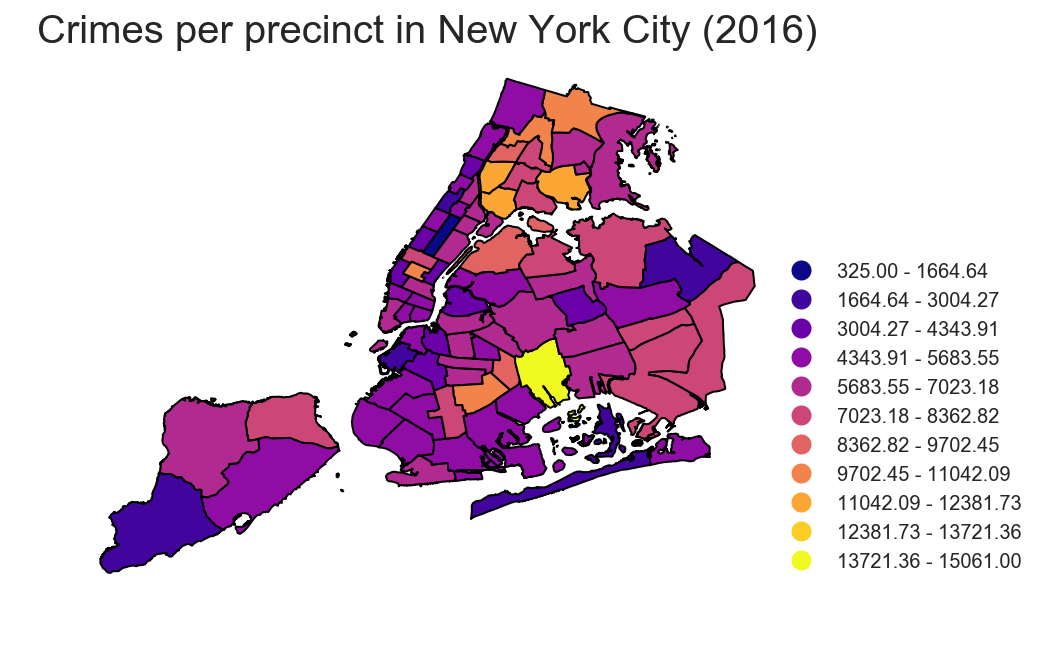

In [294]:
PreMap = NYC_precincts.to_crs(epsg = 2260).plot(column = 'cmplnt_num', scheme = 'equal_interval', k = 11, cmap = 'plasma', legend=True,
                           linewidth = 1, edgecolor = 'black', figsize = (9,5))
PreMap.set_title("Crimes per precinct in New York City (2016)", fontsize = 20)
PreMap.set_axis_off()

PreMap.get_legend().set_bbox_to_anchor((1.35, .65))
PreMap.get_legend().get_frame().set_linewidth(0)

We also examined parks in NYC.

In [295]:
comAreas = gpd.read_file("geojson files/geojson files/Community Districts.geojson").to_crs(epsg = 32118)

In [296]:
parks  = gpd.read_file("geojson files/geojson files/NY_Open Space (Parks).geojson").to_crs(epsg = 32118)

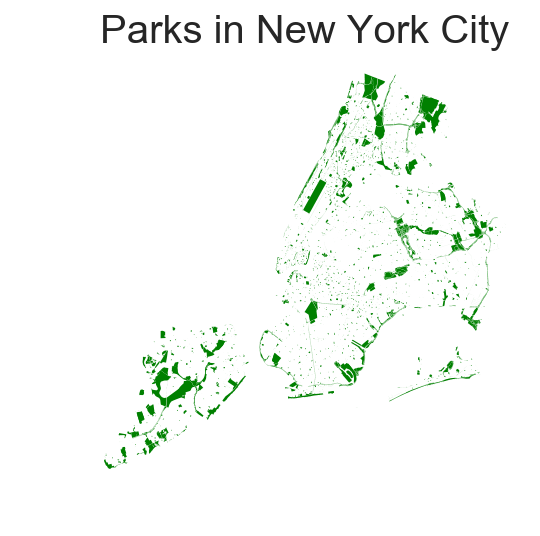

In [297]:
NYCPark = parks.plot(color = 'green')

NYCPark.set_axis_off()
NYCPark.set_title('Parks in New York City', fontsize = 20)

In [298]:
puu = parks.unary_union
cuu = comAreas.unary_union

In [299]:
comAreas["park_area"] = comAreas.centroid.buffer(500).intersection(puu).area
comAreas["distance"] = comAreas.centroid.distance(puu)

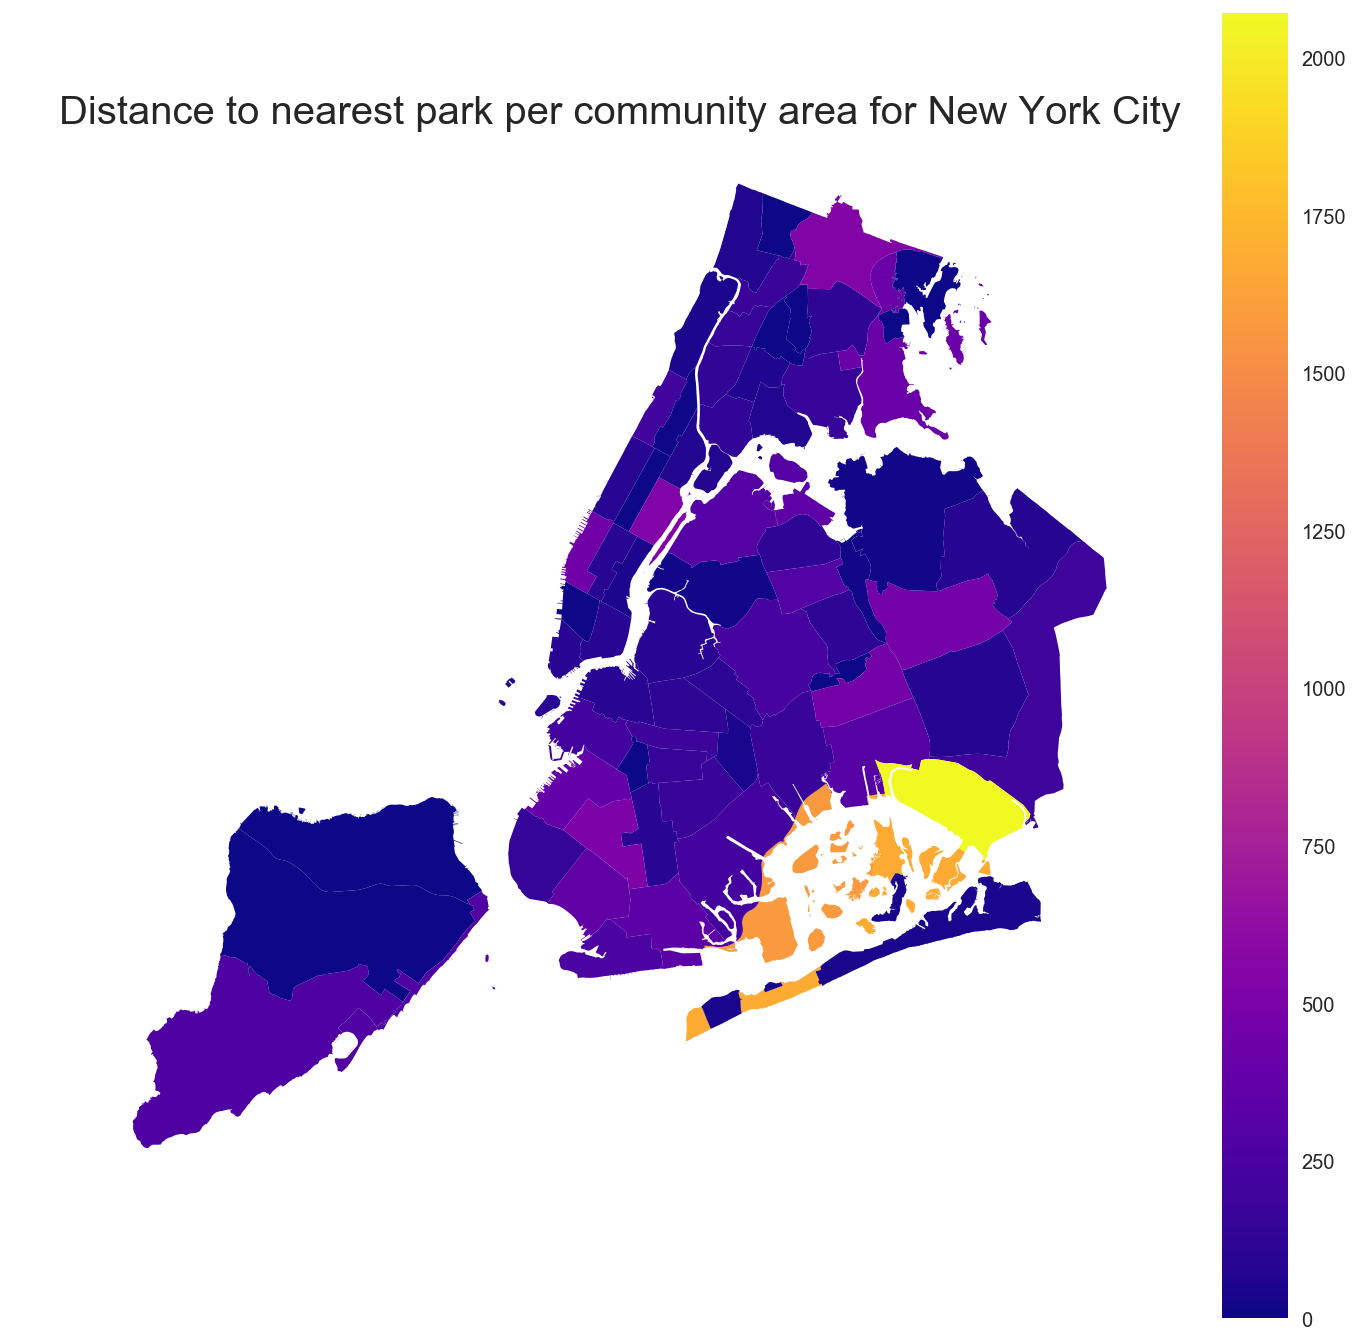

In [300]:
NYCCA = comAreas.plot(column = 'distance', cmap = 'plasma', legend = True, figsize = (12, 12))
NYCCA.set_axis_off()
NYCCA.set_title('Distance to nearest park per community area for New York City', fontsize = 20)

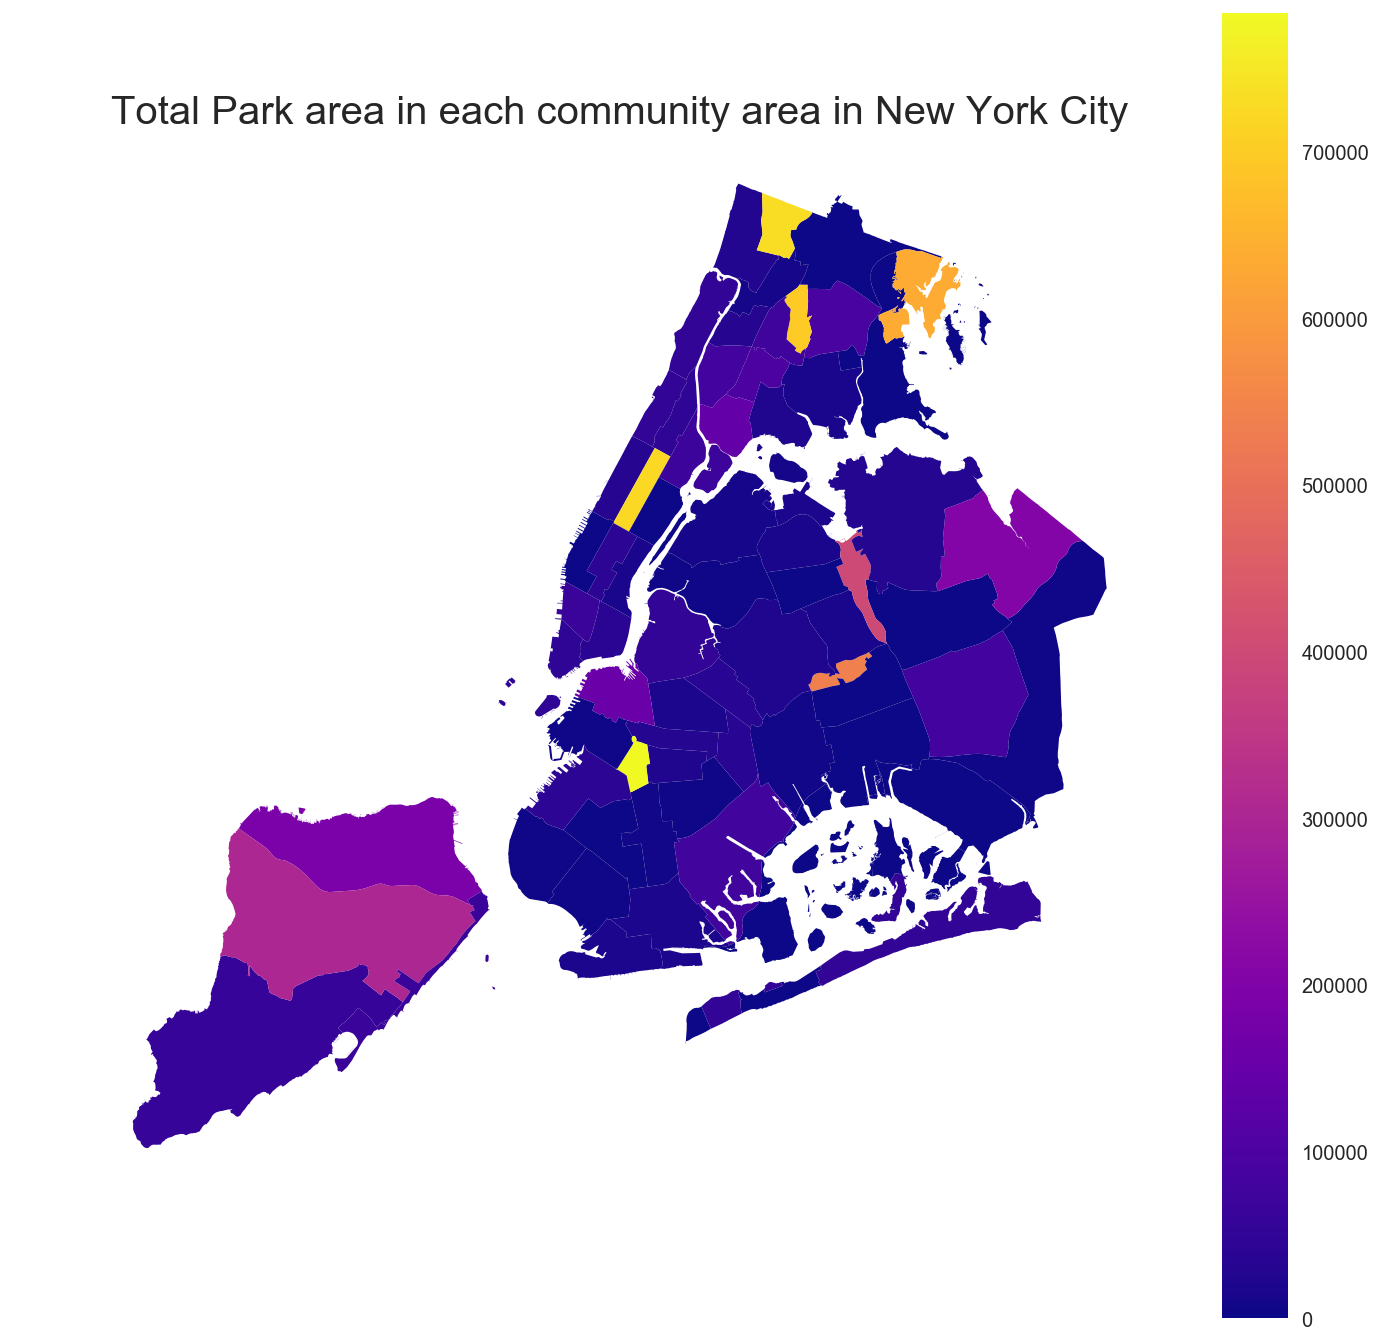

In [301]:
NYCPA = comAreas.plot(column = 'park_area', cmap = 'plasma', legend = True, figsize = (12, 12))
NYCPA.set_axis_off()
NYCPA.set_title('Total Park area in each community area in New York City', fontsize = 20)

Based upon these maps, it appears that a majority of NYC has fairly close proximity to parks, and it may not be worth assessing the relationship between crime and park distance.

# Boston

Looking at crime and parks in Boston yields a similar story. 

In [302]:
Boston_crime = pd.read_csv("Boston_crime.csv", usecols = ['OFFENSE_CODE', 'DISTRICT'])

In [303]:
Boston_crime.dropna(inplace = True)

In [304]:
Boston_crime = Boston_crime.groupby('DISTRICT').count()

In [305]:
Boston = gpd.read_file('./Police_Districts/Police_Districts.shp')

In [306]:
BostonMerge = Boston.merge(Boston_crime, left_on='DISTRICT', right_index=True)

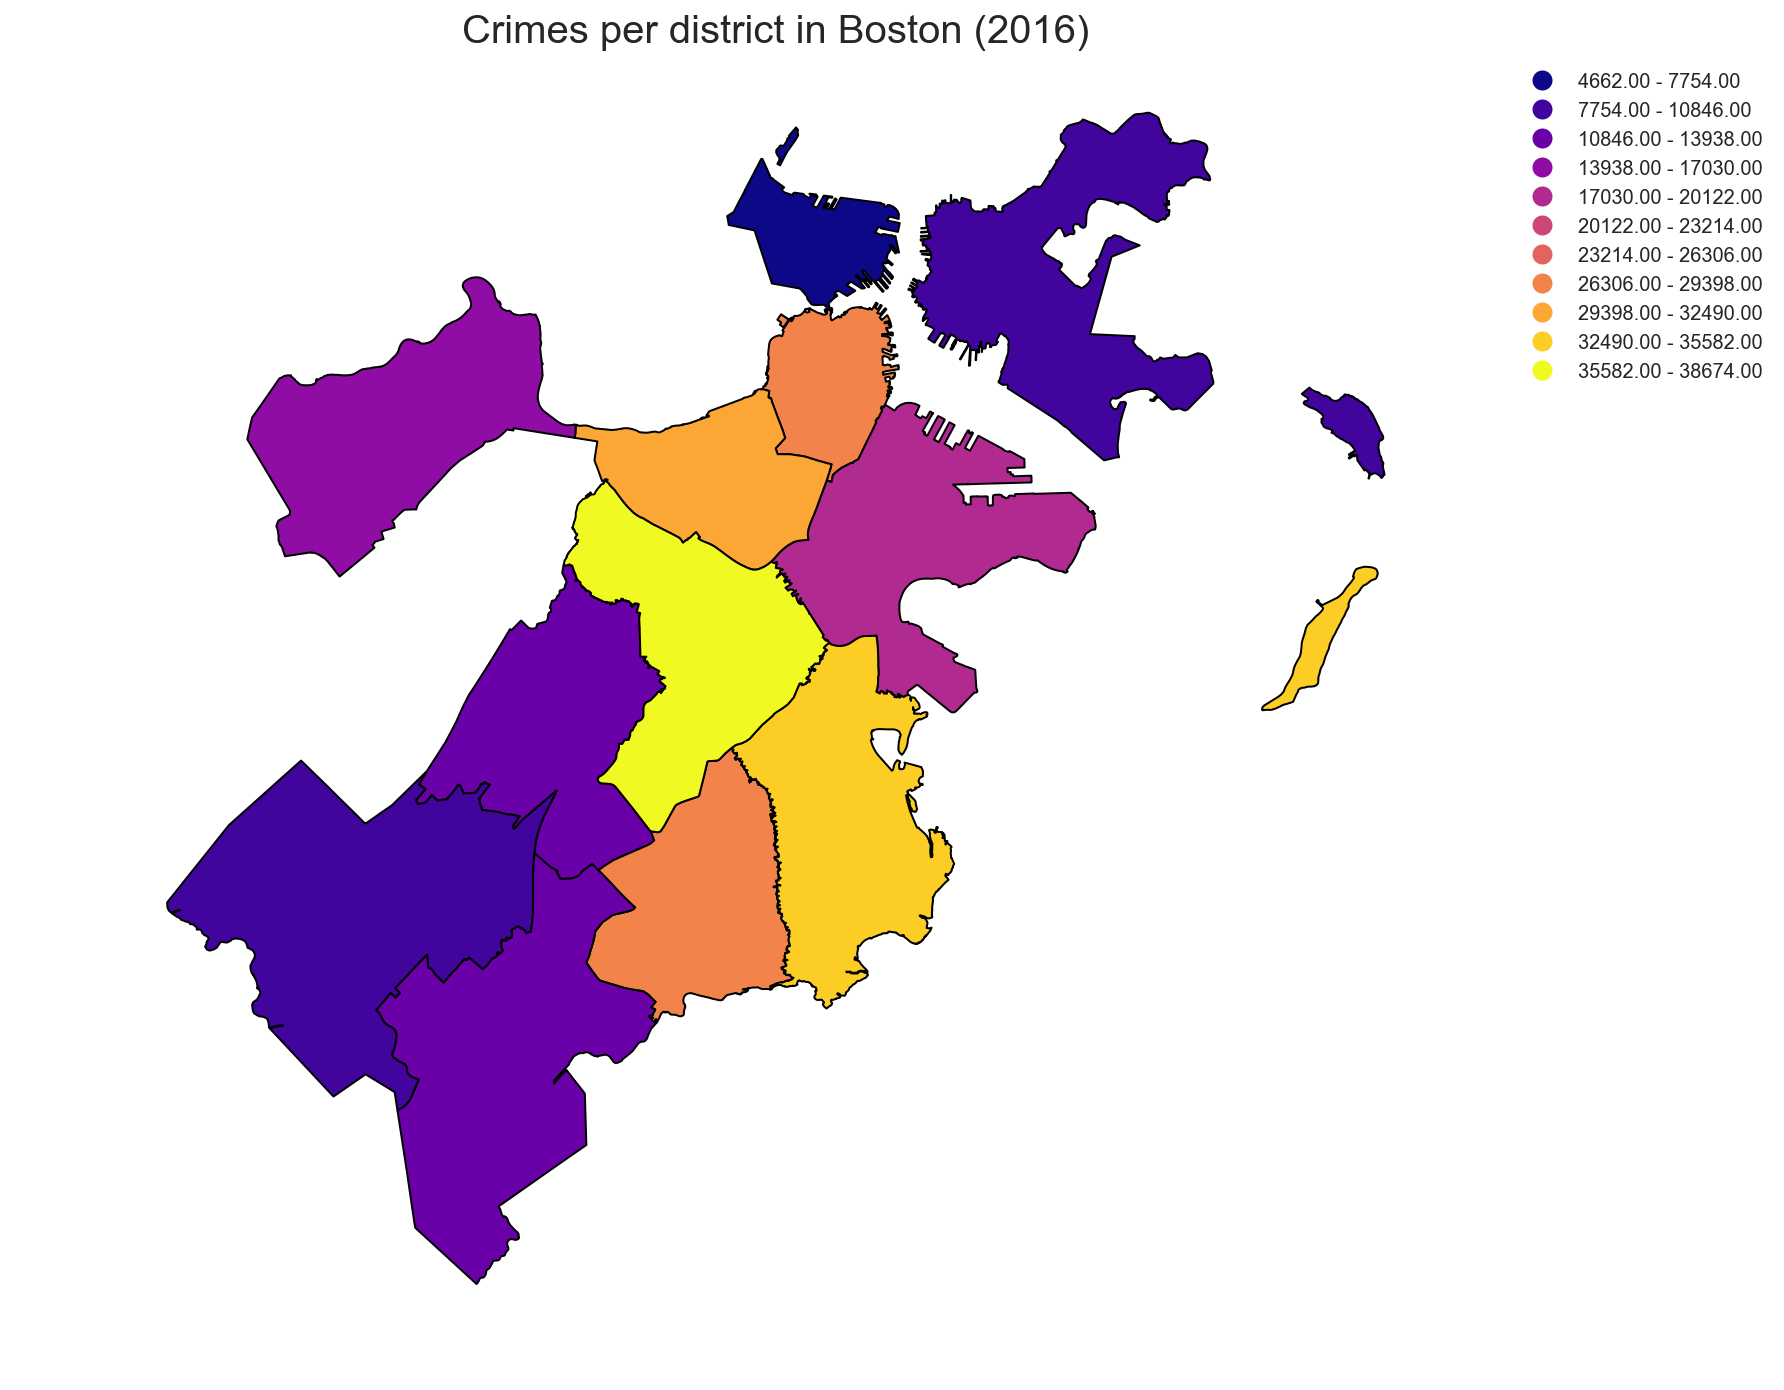

In [361]:
BoMap = BostonMerge.to_crs(epsg=2249).plot(column = 'OFFENSE_CODE', scheme = 'equal_interval', k = 11, cmap = 'plasma',
                                           legend=True, linewidth = 1, edgecolor = 'black', figsize = (12, 12))
BoMap.set_title("Crimes per district in Boston (2016)", fontsize = 20)
BoMap.set_axis_off()

BoMap.get_legend().set_bbox_to_anchor((1.25, 1))

In [308]:
neighborhoods = gpd.read_file("geojson files/geojson files/Boston_Neighborhoods.geojson").to_crs(epsg = 2249)

In [309]:
parks = gpd.read_file("geojson files/geojson files/Boston_Open_Space.geojson").to_crs(epsg = 2249)

In [310]:
puu = parks.unary_union
nuu = neighborhoods.unary_union

In [311]:
#neighborhoods["park_area"] = neighborhoods.centroid.buffer(500).intersection(puu).area
neighborhoods["distance"] = neighborhoods.centroid.distance(puu)

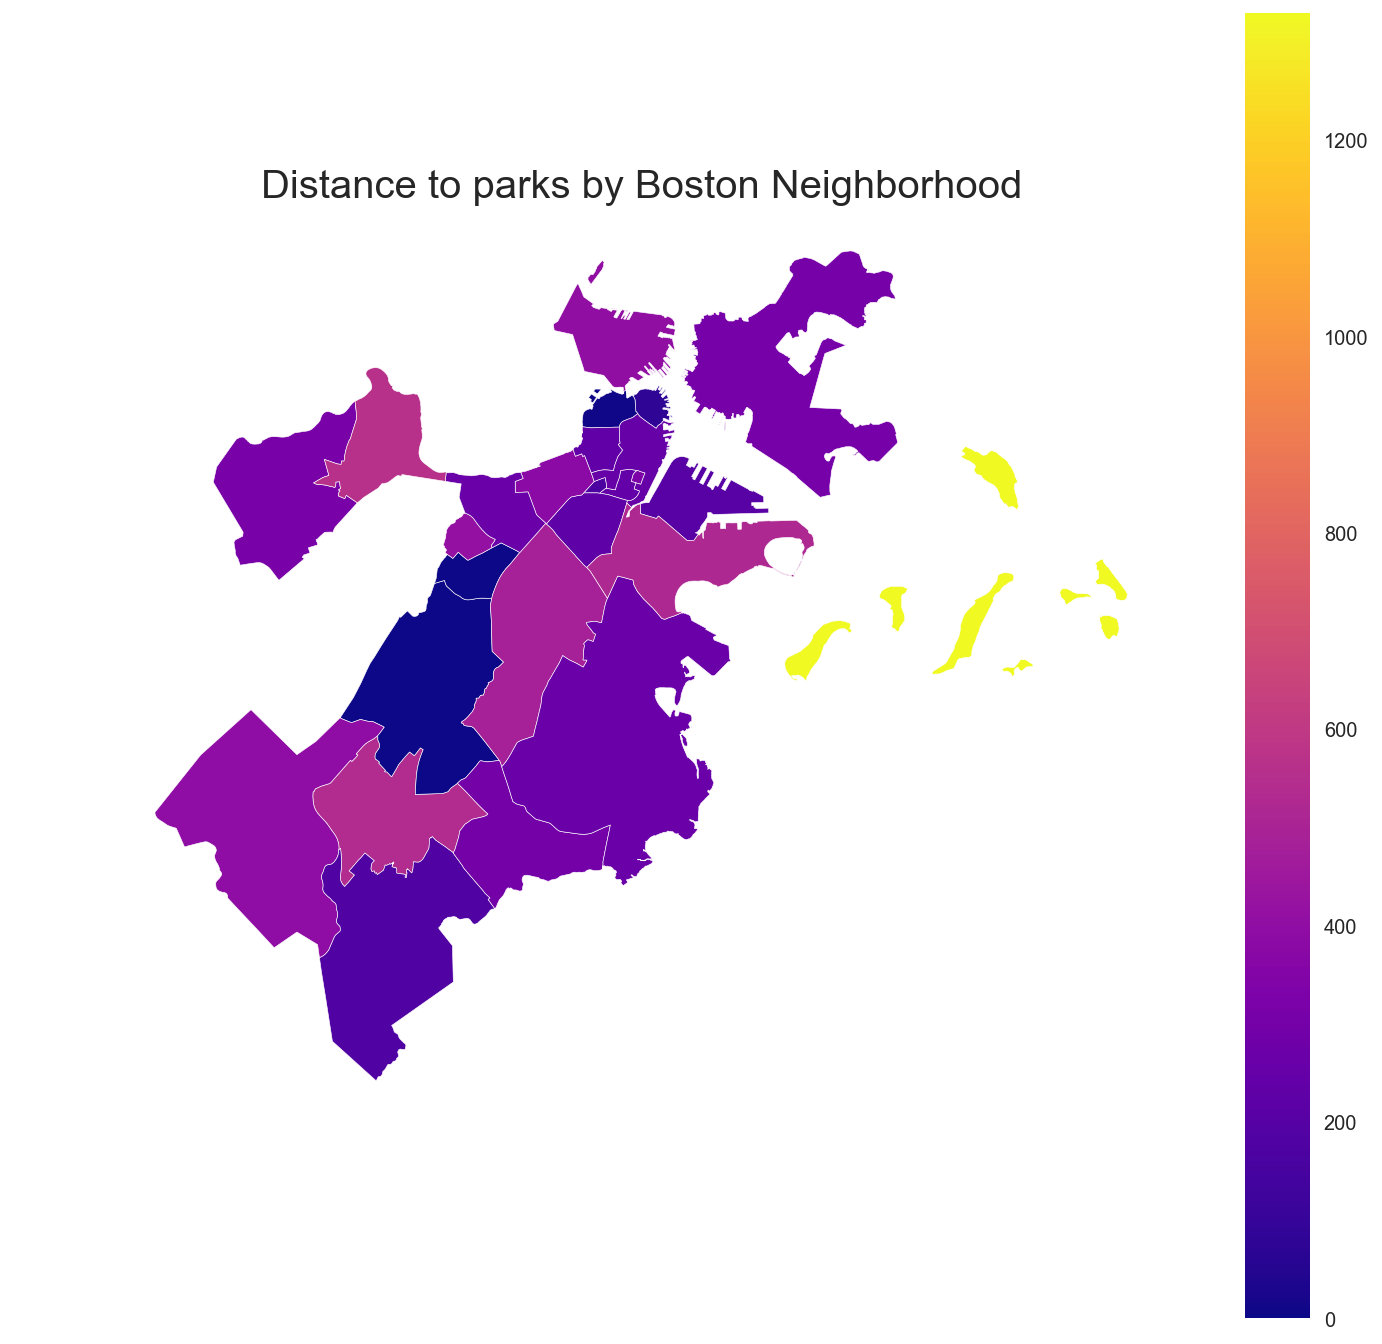

In [352]:
BON = neighborhoods.plot(column = 'distance', edgecolor = 'white', cmap = 'plasma', legend =True, figsize = (12, 12))
BON.set_axis_off()
BON.set_title('Distance to parks by Boston Neighborhood', fontsize = 20)

Given the proximity to water, the islands marked as being far from parks still have access to amenities. Given the size of neighborhood units, it does not seem overly evocative. So we decided not to explore further.

# Philadelphia

We also briefly examine Philadelphia.

In [313]:
sql = "https://phl.carto.com/api/v2/sql?q="
sql += quote("SELECT * ")
sql += quote('FROM incidents_part1_part2 ')
sql += quote("WHERE dispatch_date LIKE '2016-%' ")
sql += quote("LIMIT 200000")

resp = requests.get(sql).json()

In [314]:
resp.keys()

dict_keys(['rows', 'time', 'fields', 'total_rows'])

In [315]:
Philly = pd.DataFrame.from_dict(resp['rows'])

In [316]:
Philly_count = Philly.groupby('dc_dist').count()["psa"]

In [317]:
Philly_count = pd.DataFrame(Philly_count)

In [318]:
Philly_PD = gpd.read_file("./Boundaries_District/Boundaries_District.shp")

In [319]:
Philly_PD.head()

OBJECTID  AREA     PERIMETER  DISTRICT_ DISTRICT_I  DIST_NUM SUM_AREA  \
0       321  None  81903.641825          1       None         1     None   
1       322  None  63587.369399          2       None         2     None   
2       323  None  55305.496227          3       None         3     None   
3       324  None  71919.797243          5       None         5     None   
4       325  None  34655.320856          6       None         6     None   

  DIST_NUMC                      LOCATION     PHONE DIV_CODE     AREA_SQMI  \
0        01           24th St. & Wolf St.  686-3010      SPD  2.163501e+08   
1        02    Harbison Ave. & Levick St.  686-3020     NEPD  1.923461e+08   
2        03        11th St. & Wharton St.  686-3030      SPD  1.839049e+08   
3        05  Ridge Ave. & Cinnaminson St.  686-3050     NWPD  2.130442e+08   
4        06         11th St. & Winter St.  686-3060      CPD  6.927927e+07   

                                            geometry  
0  POLYGON ((-75.1972400674602 39.9294369069777, ...  
1  POLYGON ((-75.0544438272491 40.0445408366907, ...  
2  POLYGON ((-75.1320532000924 39.8993215193001, ...  
3  POLYGON ((-75.20429961961899 40.034678202574, ...  
4  POLYGON ((-75.1343658526971 39.9529396074571, ...

In [320]:
Philly_merge = pd.merge(Philly_PD, Philly_count, left_on = "DIST_NUMC", right_index = True)

In [321]:
Philly_merge.head()

OBJECTID  AREA     PERIMETER  DISTRICT_ DISTRICT_I  DIST_NUM SUM_AREA  \
0       321  None  81903.641825          1       None         1     None   
1       322  None  63587.369399          2       None         2     None   
2       323  None  55305.496227          3       None         3     None   
3       324  None  71919.797243          5       None         5     None   
4       325  None  34655.320856          6       None         6     None   

  DIST_NUMC                      LOCATION     PHONE DIV_CODE     AREA_SQMI  \
0        01           24th St. & Wolf St.  686-3010      SPD  2.163501e+08   
1        02    Harbison Ave. & Levick St.  686-3020     NEPD  1.923461e+08   
2        03        11th St. & Wharton St.  686-3030      SPD  1.839049e+08   
3        05  Ridge Ave. & Cinnaminson St.  686-3050     NWPD  2.130442e+08   
4        06         11th St. & Winter St.  686-3060      CPD  6.927927e+07   

                                            geometry   psa  
0  POLYGON ((-75.1972400674602 39.9294369069777, ...  3432  
1  POLYGON ((-75.0544438272491 40.0445408366907, ...  8793  
2  POLYGON ((-75.1320532000924 39.8993215193001, ...  7300  
3  POLYGON ((-75.20429961961899 40.034678202574, ...  2392  
4  POLYGON ((-75.1343658526971 39.9529396074571, ...  7773

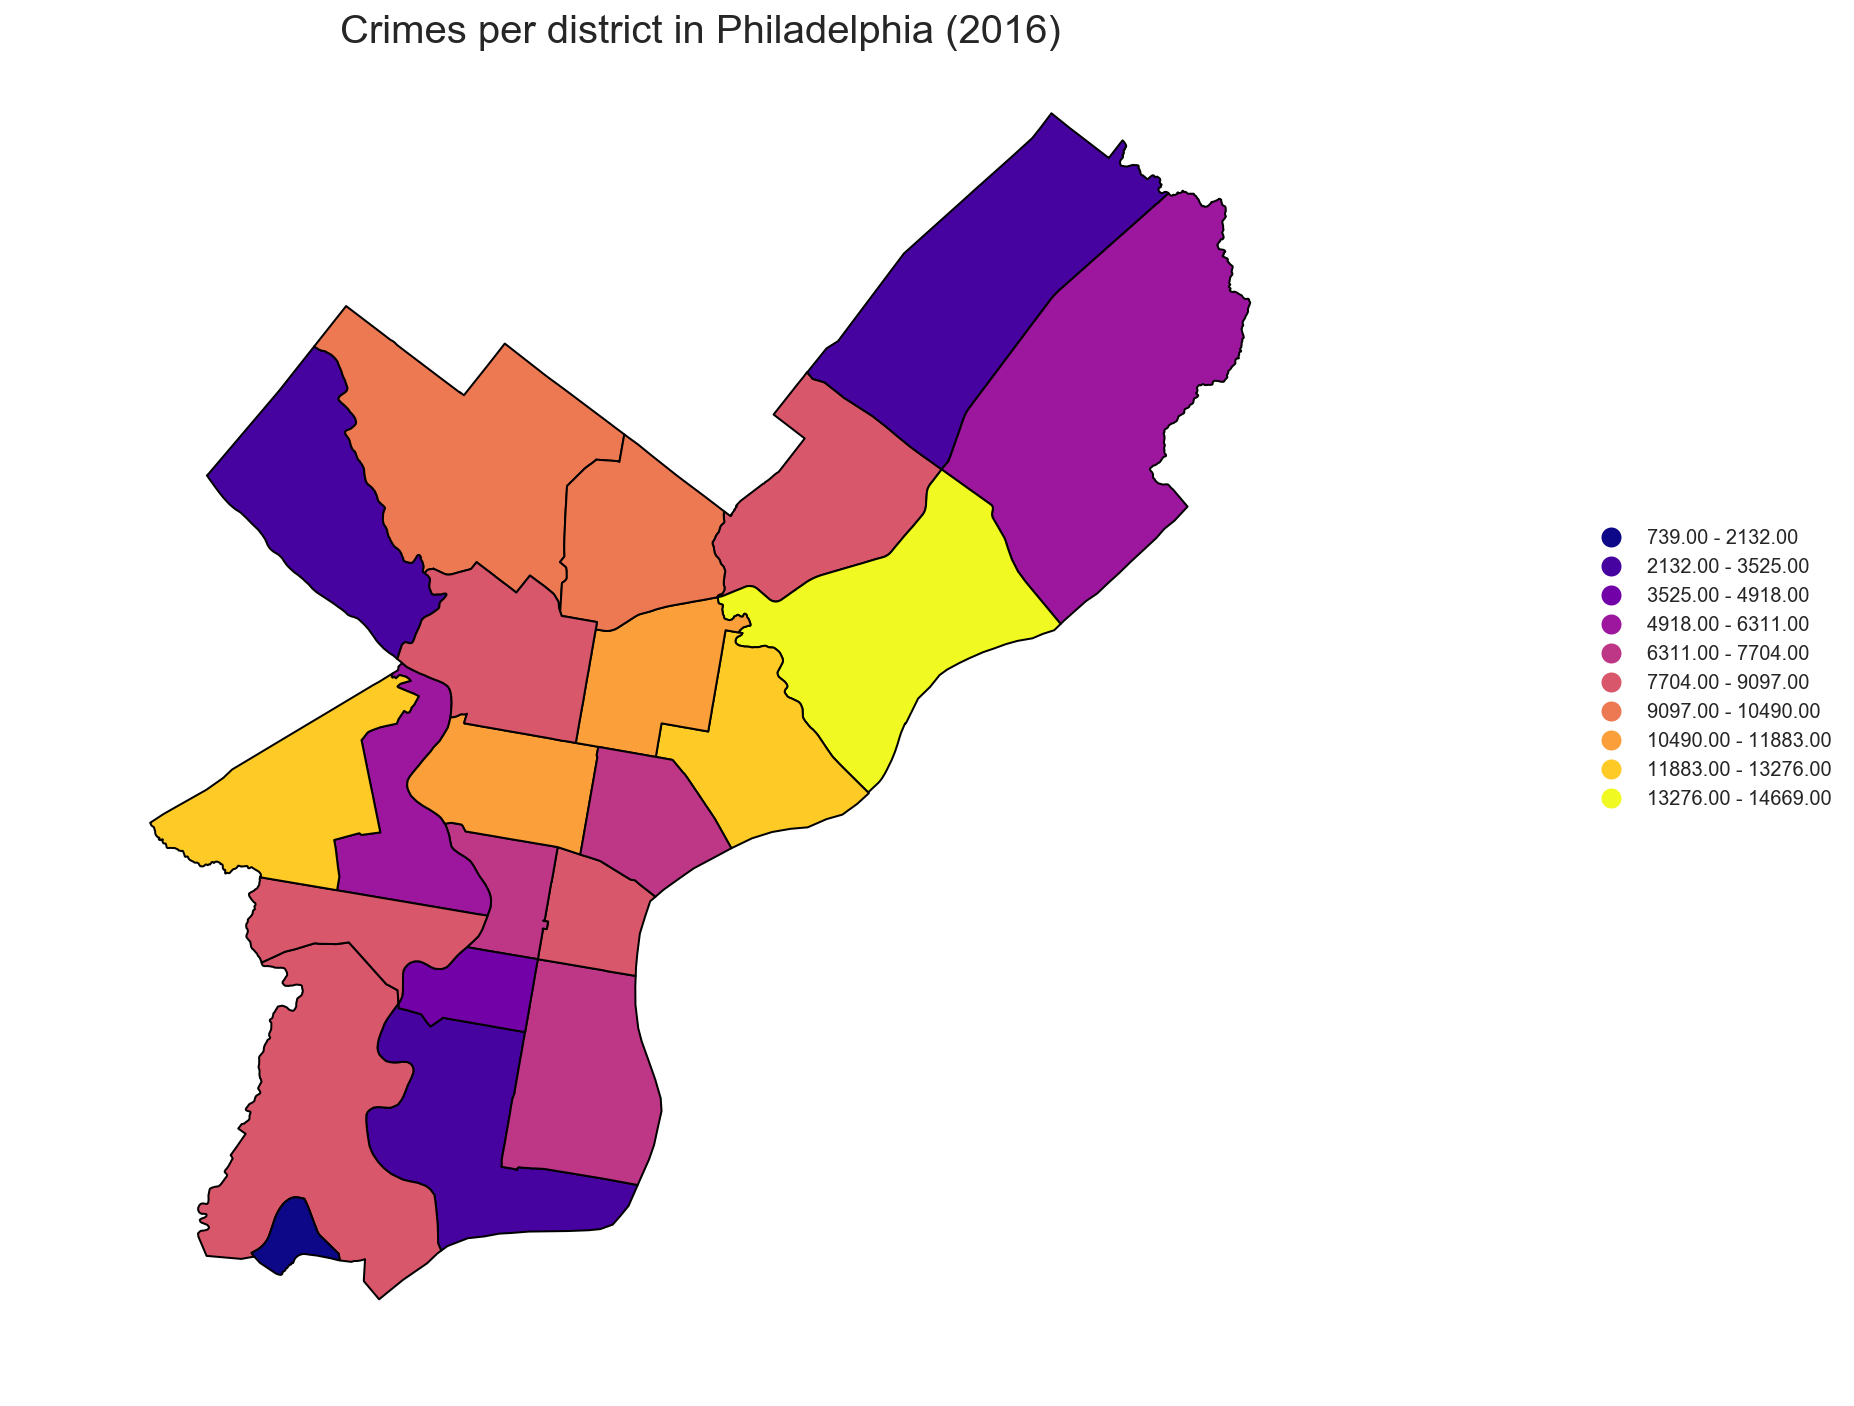

In [351]:
PhillyMap = Philly_merge.to_crs(epsg=2824).plot(column = 'psa', scheme = 'equal_interval', k = 10, cmap = 'plasma',
                                           legend=True, linewidth = 1, edgecolor = 'black', figsize = (12, 12))
PhillyMap.set_title("Crimes per district in Philadelphia (2016)", fontsize = 20)
PhillyMap.set_axis_off()

PhillyMap.get_legend().set_bbox_to_anchor((1.45, .65))

In [323]:
comAreas = gpd.read_file("geojson files/geojson files/gn-philadelphia.geojson").to_crs(epsg = 2272)

In [324]:
parks  = gpd.read_file("geojson files/geojson files/PPR_Assets.geojson").to_crs(epsg = 2272)

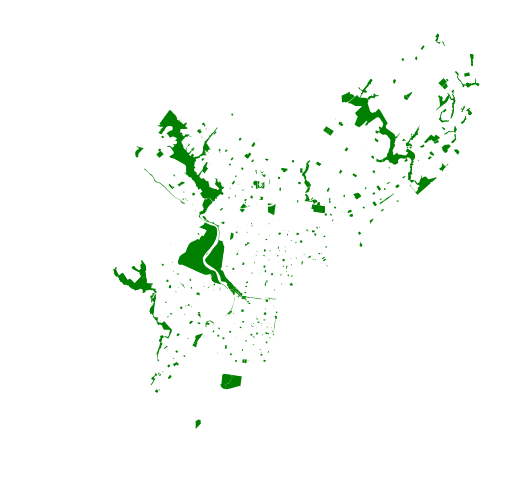

In [325]:
puu = parks.unary_union
cuu = comAreas.unary_union

parks.plot(color = "green").set_axis_off()

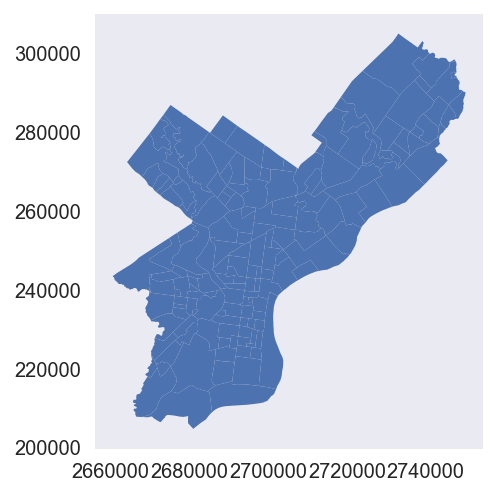

In [326]:
comAreas.plot()

In [327]:
comAreas["park_area"] = comAreas.centroid.buffer(500).intersection(puu).area
comAreas["distance"] = comAreas.centroid.distance(puu)

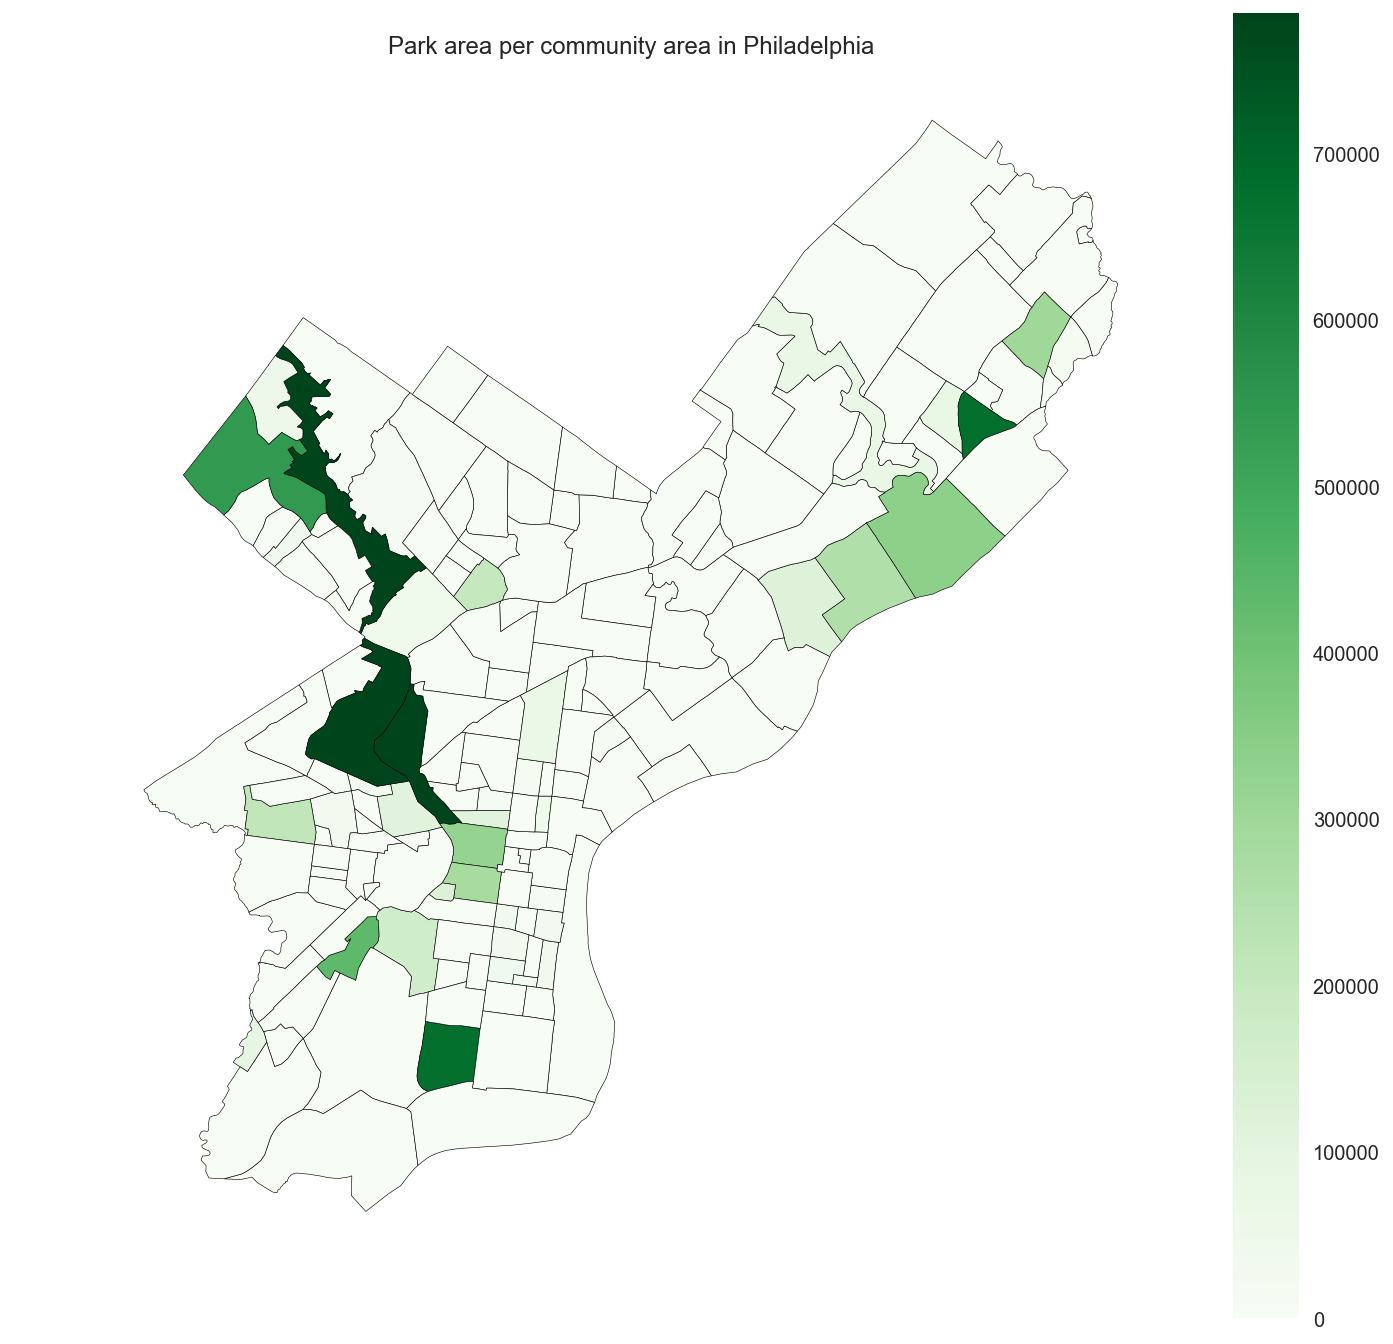

In [328]:
PHCA = comAreas.plot(column = "park_area", edgecolor = 'black', cmap = "Greens", legend = True, figsize = (12, 12))
PHCA.set_axis_off()
PHCA.set_title('Park area per community area in Philadelphia')

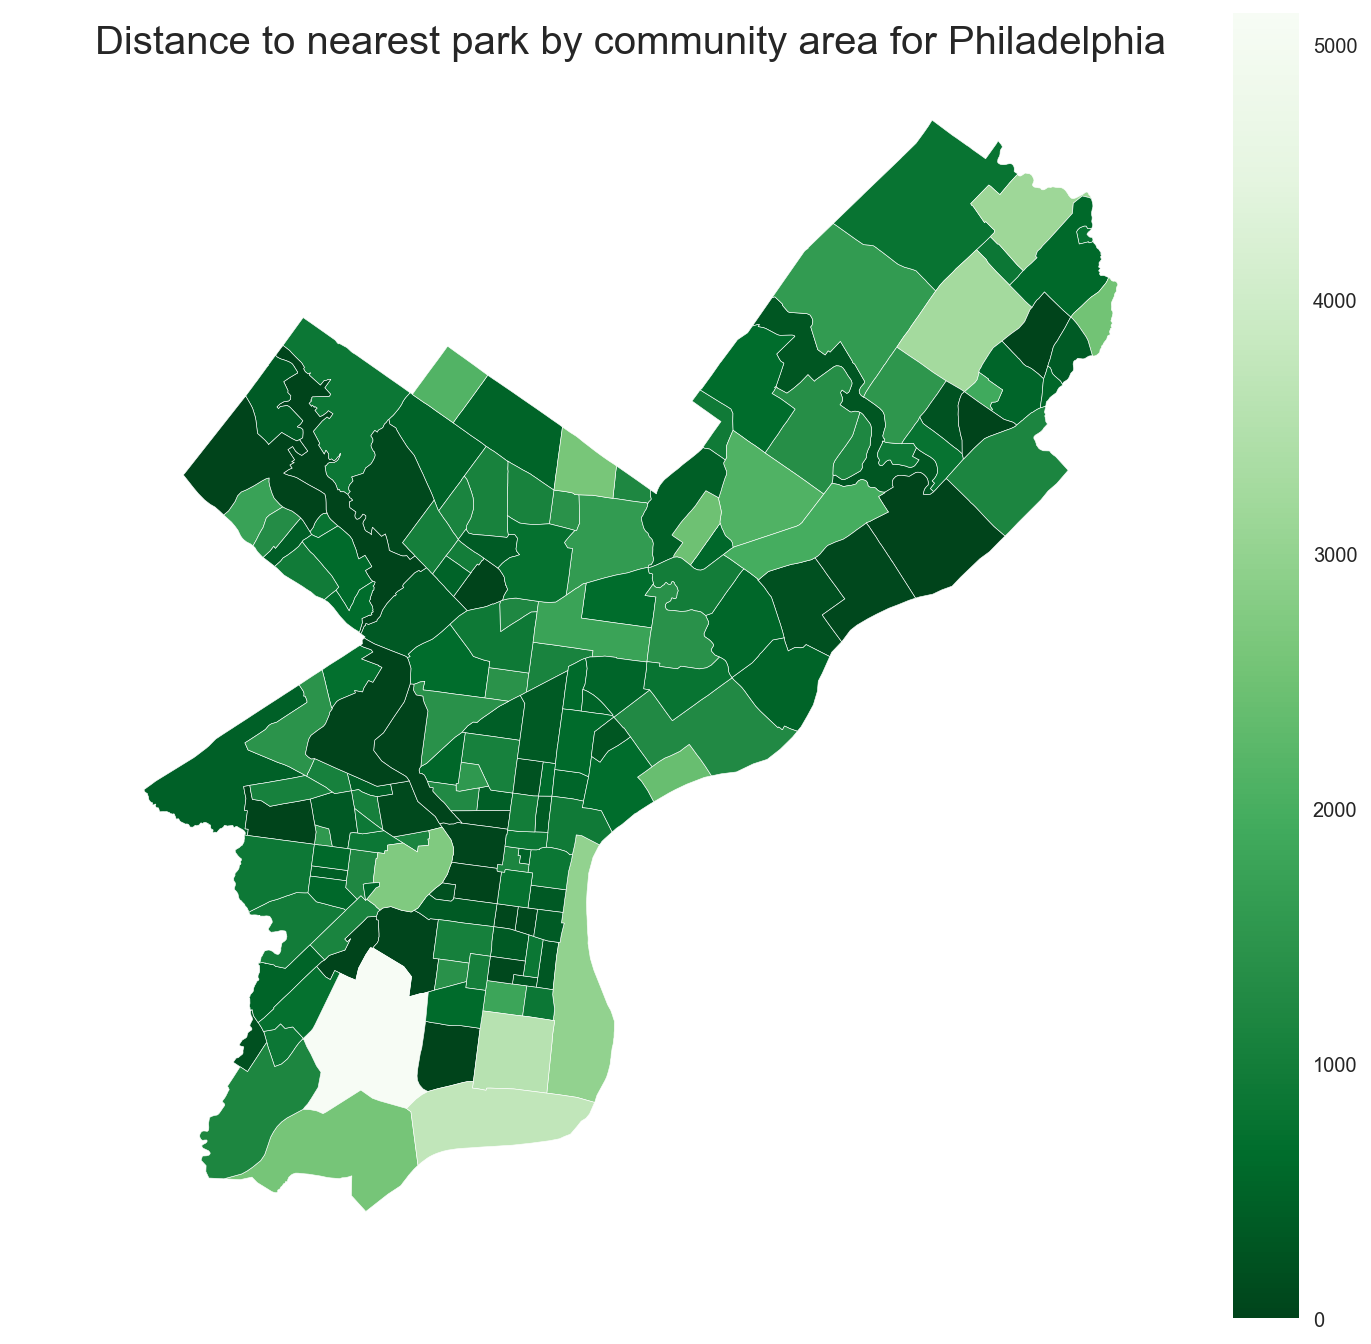

In [329]:
PHD = comAreas.plot(column = 'distance', cmap = "Greens_r", edgecolor = 'white', legend = True, figsize = (12, 12))
PHD.set_axis_off()
PHD.set_title('Distance to nearest park by community area for Philadelphia', fontsize = 20)

Again, there seems to be great uniformity among the distance and area in each community area.

# San Francisco

Finally we look at San Francisco.

In [330]:
soql = "https://data.sfgov.org/resource/cuks-n6tp.json?$query="
soql += quote("SELECT * ")
soql += quote("WHERE date_trunc_y(date) = '2016-01-01T00:00:00.000' ")
soql += quote("LIMIT 300000")

resp = requests.get(soql).json()
SF_crime = pd.DataFrame(resp)

In [331]:
SF_crime_count = SF_crime.groupby('pddistrict').count()['incidntnum']

In [332]:
SF_crime_count = pd.DataFrame(SF_crime_count)

In [333]:
soql = "https://data.sfgov.org/resource/q52f-skbd.json?$query="
soql += quote("SELECT district, the_geom ")
soql += quote("LIMIT 500")

resp = requests.get(soql).json()

In [334]:
data = resp
for d in data:
    d['the_geom'] = shape(d['the_geom'])

SF_precincts = gpd.GeoDataFrame(data).set_geometry('the_geom')
SF_precincts.head()

district                                           the_geom
0    SOUTHERN  (POLYGON ((-122.3918613881226 37.7942468097054...
1     BAYVIEW  (POLYGON ((-122.3809828136006 37.7648002201901...
2     MISSION  (POLYGON ((-122.4095391743523 37.769317718404,...
3    NORTHERN  (POLYGON ((-122.4337921715291 37.8079301070697...
4  TENDERLOIN  (POLYGON ((-122.4021713308171 37.7862601311238...

In [335]:
SF_crime_count.head()

incidntnum
pddistrict            
BAYVIEW          14339
CENTRAL          17691
INGLESIDE        11613
MISSION          19539
NORTHERN         20128

In [336]:
SF_merge = pd.merge(SF_precincts, SF_crime_count, left_on = 'district', right_index = True)

In [337]:
SF_merge.head()

district                                           the_geom  incidntnum
0    SOUTHERN  (POLYGON ((-122.3918613881226 37.7942468097054...       28527
1     BAYVIEW  (POLYGON ((-122.3809828136006 37.7648002201901...       14339
2     MISSION  (POLYGON ((-122.4095391743523 37.769317718404,...       19539
3    NORTHERN  (POLYGON ((-122.4337921715291 37.8079301070697...       20128
4  TENDERLOIN  (POLYGON ((-122.4021713308171 37.7862601311238...        9952

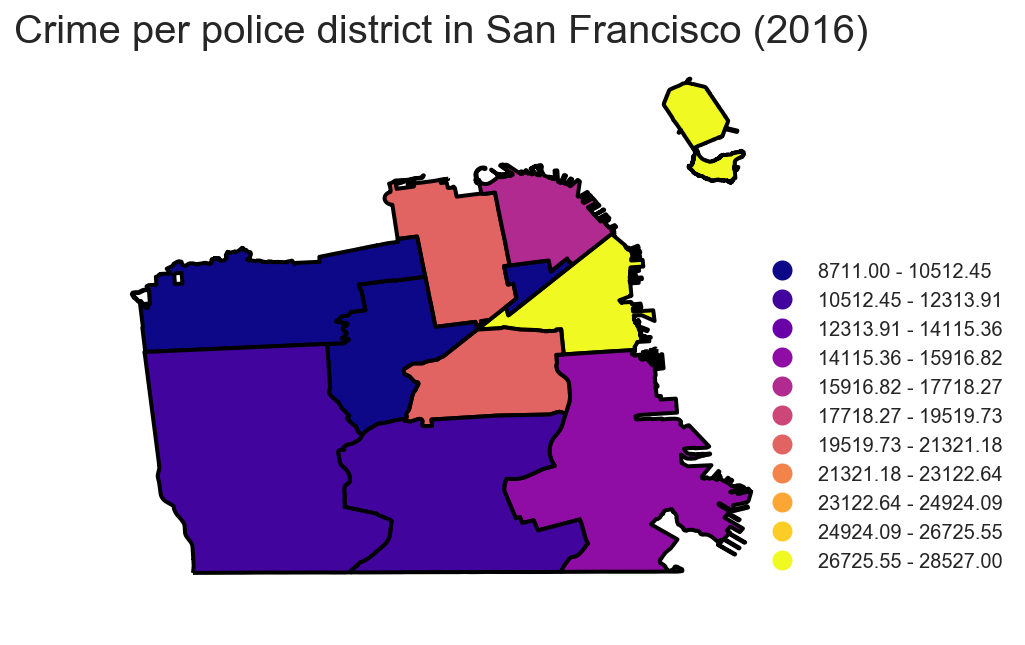

In [338]:
SFMap = SF_merge.plot(column = 'incidntnum', scheme = "equal_interval", k = 11, cmap = 'plasma', legend=True,
             linewidth = 2, edgecolor = "black", figsize = (9, 5))

SFMap.set_title("Crime per police district in San Francisco (2016)", fontsize = 20)
SFMap.set_axis_off()
SFMap.get_legend().set_bbox_to_anchor((1.35, .65))
SFMap.get_legend().get_frame().set_linewidth(0)

In [339]:
parks  = gpd.read_file("geojson files/geojson files/Park Lands - Recreation and Parks Department.geojson").to_crs(epsg = 2226)

In [340]:
parks = parks[~parks['map_park_n'].str.contains('Mather')]

In [341]:
tracts = gpd.read_file('geojson files/geojson files/Census 2010_ Tracts for San Francisco.geojson').to_crs(epsg = 2226)

In [342]:
tracts = tracts[tracts['namelsad10']!='Census Tract 9804.01']

In [343]:
tracts = tracts[tracts['namelsad10']!='Census Tract 9901']

In [344]:
tracts = tracts[tracts['namelsad10']!='Census Tract 179.02']

In [345]:
tracts = tracts[tracts['namelsad10']!='Census Tract 601']

In [346]:
puu = parks.unary_union
tuu = tracts.unary_union

In [347]:
tracts['park_area'] = tracts.centroid.buffer(500).intersection(puu).area

In [348]:
tracts["distance"] = tracts.centroid.distance(puu)

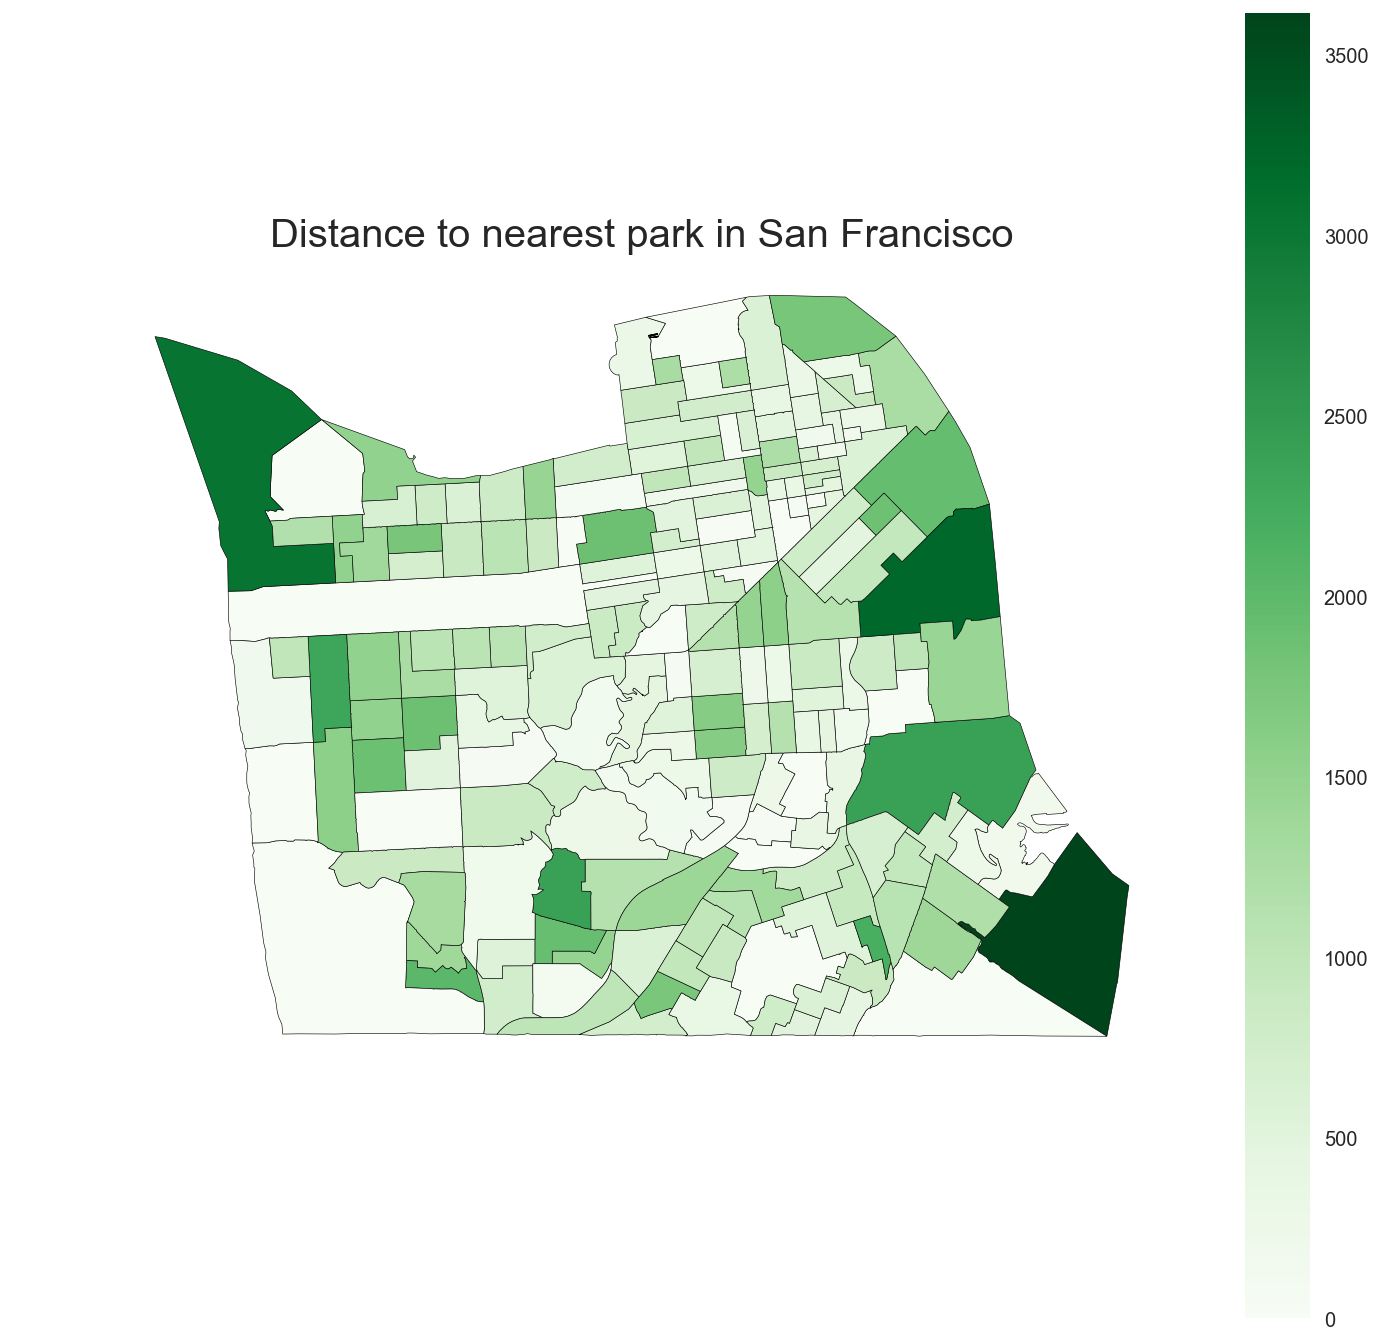

In [349]:
SFTD = tracts.plot(column = 'distance', cmap = "Greens", edgecolor = 'black', legend = True, figsize = (12, 12))
SFTD.set_axis_off()
SFTD.set_title('Distance to nearest park in San Francisco', fontsize = 20)

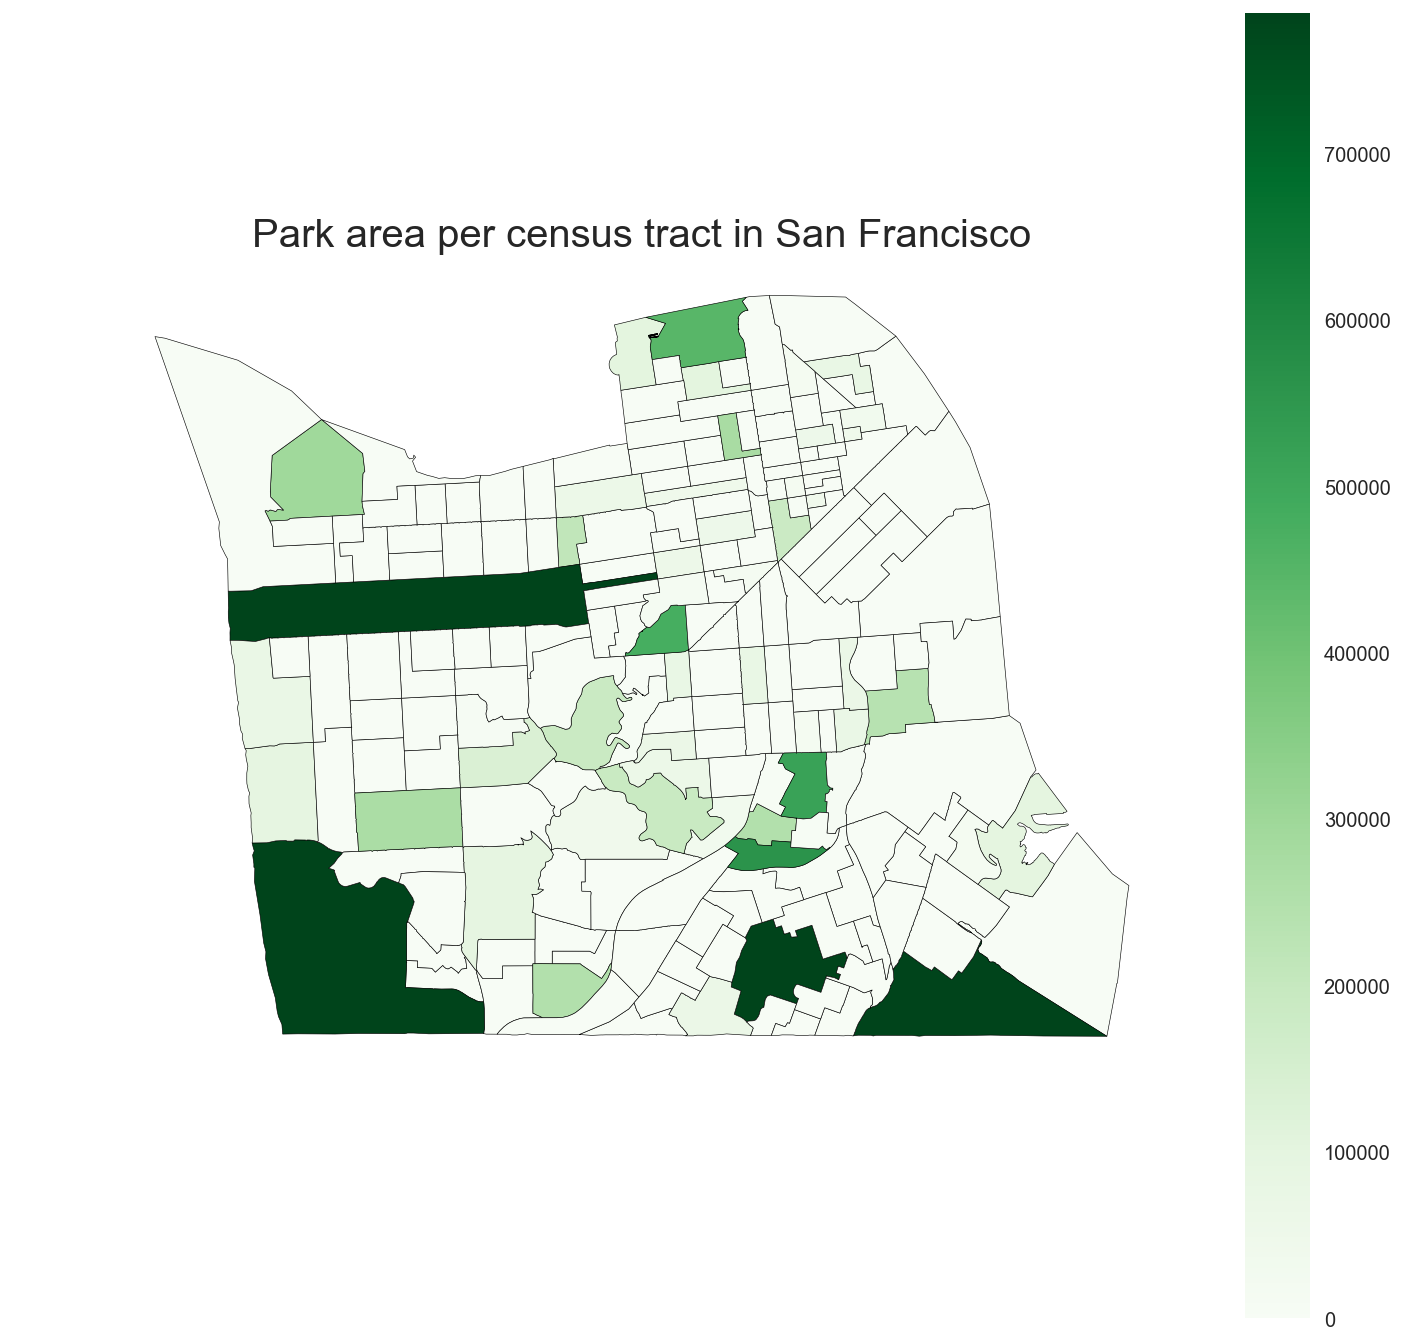

In [354]:
SFTA = tracts.plot(column = 'park_area', edgecolor = 'black', cmap = "Greens", legend = True, figsize= (12, 12))
SFTA.set_axis_off()
SFTA.set_title('Park area per census tract in San Francisco', fontsize = 20)

With the exception of census tracts that are literally made up of parks, like Golden Gate Park, Lake Merced Park, and John McLaren Park, the rest of the city appears to be fairly evenly distributed in park_area. Again, we chose not to analyze the city given the uniformity, believe Chicago to be a similar enough test case of whether further investigation was necessary.